In [1]:
# ======================================================
# Importation of Libraries
#      
# Michael Collins, Flatiron School
# 2020-10-30_0639_MDT
#
# ======================================================
import math
from IPython.display import display
from openlocationcode import openlocationcode as olc
from geographiclib.geodesic import Geodesic
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as scs
from scipy.stats import median_abs_deviation as MAD
import statsmodels.api as sm
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import flatiron.statsFunctions as sf
from importlib import reload
reload(sf)
import plotly.express as px
import requests


In [2]:
# ======================================================
# K-Nearest-Neighbor Evaluation
#      
# Suppose we are given:
#      * a number of events "N"
#      * a list of event indices "event_i"
#      * a list of event coordinates "event_latlng"
#      * some number of events "K" < N
#      * the coordinates "Q_latlng" of some arbitrary 
#            point Q on earth's surface
#
# The code in this cell returns [the list of indices for
# the K events whose proximity is nearest to point Q]
# for each of the N events.
#
# Michael Collins, Flatiron School
# 2020-10-28_0524_MDT
#
# ======================================================

OLC_CODE_PLANET = "00000000+"
OLC_EARTH_CIRCUMFERENCE = np.round(2 * np.pi * Geodesic.WGS84.a, 3)
OLC_LATITUDE_SPAN = 180.0
OLC_LATITUDE_SOUTH_POLE = -90.0
OLC_LATITUDE_EQUATOR = 0.0
OLC_LATITUDE_NORTH_POLE = 90.0
OLC_LONGITUDE_SPAN = 360.0
OLC_LONGITUDE_DATELINE_WEST = -180.0
OLC_LONGITUDE_GREENWICH = 0.0
OLC_LONGITUDE_DATELINE_EAST = 180.0

OLC_PYLON_MIDPOINT = "midpoint"
OLC_PYLON_O = OLC_PYLON_MIDPOINT
OLC_PYLON_N = "pylon_N"
OLC_PYLON_NE = "pylon_NE"
OLC_PYLON_E = "pylon_E"
OLC_PYLON_SE = "pylon_SE"
OLC_PYLON_S = "pylon_S"
OLC_PYLON_SW = "pylon_SW"
OLC_PYLON_W = "pylon_W"
OLC_PYLON_NW = "pylon_NW"
OLC_BORDER_PYLONs = [OLC_PYLON_N, OLC_PYLON_NE, OLC_PYLON_E, OLC_PYLON_SE,
                     OLC_PYLON_S, OLC_PYLON_SW, OLC_PYLON_W, OLC_PYLON_NW]
OLC_PYLONs = [OLC_PYLON_O] + OLC_BORDER_PYLONs

OLC_OFFSET_N = "offset_N"
OLC_OFFSET_NE = "offset_NE"
OLC_OFFSET_E = "offset_E"
OLC_OFFSET_SE = "offset_SE"
OLC_OFFSET_S = "offset_S"
OLC_OFFSET_SW = "offset_SW"
OLC_OFFSET_W = "offset_W"
OLC_OFFSET_NW = "offset_NW"
OLC_CARDINAL_OFFSETs = [OLC_OFFSET_N, OLC_OFFSET_E, OLC_OFFSET_S, OLC_OFFSET_W]
OLC_DIAGONAL_OFFSETs = [OLC_OFFSET_NE, OLC_OFFSET_SE, OLC_OFFSET_SW, OLC_OFFSET_NW]
OLC_OFFSETs = [OLC_OFFSET_N, OLC_OFFSET_NE, OLC_OFFSET_E, OLC_OFFSET_SE,
               OLC_OFFSET_S, OLC_OFFSET_SW, OLC_OFFSET_W, OLC_OFFSET_NW]

OLC_TAU_PLANET = 0    # (180)-degree by (360)-degree resolution
OLC_TAU_DOMAIN = 1    # (20)-degree by (20)-degree resolution
OLC_TAU_SHIRE = 2     # (1)-degree by (1)-degree resolution
OLC_TAU_TOWNSHIP = 3  # (1/20)-degree by (1/20)-degree resolution
OLC_TAU_HOLLER = 4    # (1/400)-degree by (1/400)-degree resolution
OLC_TAU_ROOFTOP = 5   # (1/8000)-degree by (1/8000)-degree resolution
OLC_TAU_PARLOR = 6    # (1/40000)-degree by (1/32000)-degree resolution
OLC_TAU_DESK = 7      # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_ENVELOPE = 8  # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_ERASER = 9    # subdivides the above into a 5-tall by 4-wide grid
OLC_TAU_STAPLE = 10   # subdivides the above into a 5-tall by 4-wide grid
OLC_TAUs = [OLC_TAU_PLANET, OLC_TAU_DOMAIN, OLC_TAU_SHIRE,
            OLC_TAU_TOWNSHIP, OLC_TAU_HOLLER, OLC_TAU_ROOFTOP,
            OLC_TAU_PARLOR, OLC_TAU_DESK, OLC_TAU_ENVELOPE,
            OLC_TAU_ERASER, OLC_TAU_STAPLE]

OLC_TAU_BEDROCK = OLC_TAU_ROOFTOP
OLC_GRID_NORTH_MAX = np.prod([9, 20, 20, 20, 20][0:OLC_TAU_BEDROCK])
OLC_GRID_EAST_MAX = np.prod([18, 20, 20, 20, 20][0:OLC_TAU_BEDROCK])


OLC_TIER_PLANET = "planet"      # (180)-degree by (360)-degree resolution
OLC_TIER_DOMAIN = "domain"      # (20)-degree by (20)-degree resolution
OLC_TIER_SHIRE = "shire"        # (1)-degree by (1)-degree resolution
OLC_TIER_TOWNSHIP = "township"  # (1/20)-degree by (1/20)-degree resolution
OLC_TIER_HOLLER = "holler"      # (1/400)-degree by (1/400)-degree resolution
OLC_TIER_ROOFTOP = "rooftop"    # (1/8000)-degree by (1/8000)-degree resolution
OLC_TIER_PARLOR = "parlor"      # (1/40000)-degree by (1/32000)-degree resolution
OLC_TIER_DESK = "desk"          # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_ENVELOPE = "envelope"  # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_ERASER = "eraser"      # subdivides the above into a 5-tall by 4-wide grid
OLC_TIER_STAPLE = "staple"      # subdivides the above into a 5-tall by 4-wide grid
OLC_TIERs = [OLC_TIER_PLANET, OLC_TIER_DOMAIN, OLC_TIER_SHIRE,
             OLC_TIER_TOWNSHIP, OLC_TIER_HOLLER, OLC_TIER_ROOFTOP,
             OLC_TIER_PARLOR, OLC_TIER_DESK, OLC_TIER_ENVELOPE,
             OLC_TIER_ERASER, OLC_TIER_STAPLE]

OLC_CODELEN_PLANET = 0      # (180)-degree by (360)-degree resolution
OLC_CODELEN_DOMAIN = 2      # (20)-degree by (20)-degree resolution
OLC_CODELEN_SHIRE = 4        # (1)-degree by (1)-degree resolution
OLC_CODELEN_TOWNSHIP = 6  # (1/20)-degree by (1/20)-degree resolution
OLC_CODELEN_HOLLER = 8      # (1/400)-degree by (1/400)-degree resolution
OLC_CODELEN_ROOFTOP = 10    # (1/8000)-degree by (1/8000)-degree resolution
OLC_CODELEN_PARLOR = 11      # (1/40000)-degree by (1/32000)-degree resolution
OLC_CODELEN_DESK = 12          # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_ENVELOPE = 13  # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_ERASER = 14      # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELEN_STAPLE = 15      # subdivides the above into a 5-tall by 4-wide grid
OLC_CODELENs = [OLC_CODELEN_PLANET, OLC_CODELEN_DOMAIN, OLC_CODELEN_SHIRE,
                OLC_CODELEN_TOWNSHIP, OLC_CODELEN_HOLLER, OLC_CODELEN_ROOFTOP,
                OLC_CODELEN_PARLOR, OLC_CODELEN_DESK, OLC_CODELEN_ENVELOPE,
                OLC_CODELEN_ERASER, OLC_CODELEN_STAPLE]

OLC_tau_to_tier = dict(zip(OLC_TAUs, OLC_TIERs))
OLC_tier_to_tau = dict(zip(OLC_TIERs, OLC_TAUs))
OLC_TIER_BEDROCK = OLC_tau_to_tier[OLC_TAU_BEDROCK]

OLC_tau_to_codeLen = dict(zip(OLC_TAUs, OLC_CODELENs))

OLC_codeLen_to_tau = dict(zip(OLC_CODELENs, OLC_TAUs))

OLC_tier_to_codeLen = dict(zip(OLC_TIERs, OLC_CODELENs))

OLC_codeLen_to_tier = dict(zip(OLC_CODELENs, OLC_TIERs))

def sci_round(x, n):
    s = np.format_float_scientific(x, precision=n, trim='-')
    return float(s)

def olc_encode_tau(latlng, tau):
    if not tau in OLC_TAUs:
        return None
        
    if tau == OLC_TAU_PLANET:
        code = OLC_CODE_PLANET
    else:
        code = olc.encode(*latlng, OLC_tau_to_codeLen[tau])
    return code

def olc_add_zone_to_archive(this_zone):
    raw_dict = {}
    raw_dict[this_zone.code] = this_zone
    for child_zone in this_zone.children.values():
        child_dict = olc_add_zone_to_archive(child_zone)    
        raw_dict.update(child_dict)
    return dict(sorted(raw_dict.items()))

def olc_latitude_to_iNorth_fracN(latitude=None):
    if not isinstance(latitude, float):
        print(f"the latitude must be specified.")
        return None
    if not(OLC_LATITUDE_SOUTH_POLE <= latitude <= OLC_LATITUDE_NORTH_POLE):
        print(f"the latitude {latitude} is not valid.")
        return None
    if latitude == OLC_LATITUDE_SOUTH_POLE:
        return (0, 0.0)
    if latitude == OLC_LATITUDE_NORTH_POLE:
        return (OLC_GRID_NORTH_MAX - 1, 1.0)
    uNorth = sci_round((latitude - OLC_LATITUDE_SOUTH_POLE)*OLC_GRID_NORTH_MAX/OLC_LATITUDE_SPAN, 10)
    fN, iN = np.modf(uNorth)
    iNorth = int(iN)
    fracN = float(fN)
    return (iNorth, fracN)

def olc_longitude_to_iEast_fracE(longitude=None):
    if not isinstance(longitude, float):
        print(f"the longitude must be specified.")
        return None
    if not(OLC_LONGITUDE_DATELINE_WEST <= longitude <= OLC_LONGITUDE_DATELINE_EAST):
        print(f"the longitude {longitude} is not valid.")
        return None
    if longitude == OLC_LONGITUDE_DATELINE_WEST:
        return (0, 0.0)
    if longitude == OLC_LONGITUDE_DATELINE_EAST:
        return (OLC_GRID_EAST_MAX - 1, 1.0)
    uEast = sci_round((longitude - OLC_LONGITUDE_DATELINE_WEST)*OLC_GRID_EAST_MAX/OLC_LONGITUDE_SPAN, 10)
    fE, iE = np.modf(uEast)
    iEast = int(iE)
    fracE = float(fE)
    return (iEast, fracE)

class OLC_Offset:
    def __init__(self, lat1=None, lng1=None, lat2=None, lng2=None, mR_est=None, mN_est=None, mE_est=None):
        gripes = []
        
        has_est = True
        if mR_est is None:
            has_est = False
        if mN_est is None:
            has_est = False
        if mE_est is None:
            has_est = False
        if not has_est:
            mR_est, mN_est, mE_est = None, None, None
        
        if len(gripes) == 0:
            if has_est:
                if not isinstance(mR_est, float):
                    gripes.append(f"mR_est={mR_est} must be a floating-point number.")
                if not isinstance(mN_est, float):
                    gripes.append(f"mN_est={mN_est} must be a floating-point number.")
                if not isinstance(mE_est, float):
                    gripes.append(f"mE_est={mE_est} must be a floating-point number.")

        if len(gripes) == 0:
            if not isinstance(lat1, float):
                gripes.append(f"lat1={lat1} must be a floating point number.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= lat1 <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"lat1={lat1} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lat2, float):
                gripes.append(f"lat2={lat2} must be a floating point number.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= lat2 <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"lat2={lat2} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lng1, float):
                gripes.append(f"lng1={lng1} must be a floating point number.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= lng1 <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"lng1={lng1} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(lng2, float):
                gripes.append(f"lng2={lng2} must be a floating point number.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= lng2 <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"lng2={lng2} is not valid.")
        
        if len(gripes) == 0:
            try:
                gdict = Geodesic.WGS84.Inverse(lat1, lng1, lat2, lng2) # use the WGS84 ellipsoid
                
                # range in meters from latlng1 to latlng2 
                #      (rounded to nearest millimeter)
                range_meters_raw = gdict['s12']
                
                # components of forward azimuth at latlng1
                azi1_rad = np.radians(gdict['azi1'])          
                azi12_n = sci_round(np.cos(azi1_rad), 10)
                azi12_e = sci_round(np.sin(azi1_rad), 10)
            except:
                gripes.append(f"failure during Geodesic.WGS84.Inverse({lat1}, {lng1}, {lat2}, {lng2}).")
               
        if len(gripes) == 0:
            mR = np.round(range_meters_raw, 3)
            mN = np.round(range_meters_raw * azi12_n, 3)  # this is admittedly an estimate
            mE = np.round(range_meters_raw * azi12_e, 3)  # this is admittedly an estimate
            if has_est:
                delta_mR = np.round(mR_est - mR, 3)
                delta_mN = np.round(mN_est - mN, 3)
                delta_mE = np.round(mE_est - mE, 3)
            else:
                delta_mR = None
                delta_mN = None
                delta_mE = None

            self.valid = True
            self.latlng1 = (lat1, lng1)
            self.latlng2 = (lat2, lng2)
            self.mR = mR
            self.delta_mR = delta_mR
            self.mN = mN
            self.delta_mN = delta_mN
            self.mE = mE
            self.delta_mE = delta_mE   
            self.azi12_n = azi12_n
            self.azi12_e = azi12_e
        else:
            self.valid = False
            self.latlng1 = (lat1, lng1)
            self.latlng2 = (lat2, lng2)
            self.gripes = gripes

    def __str__(self):
        return f"|OLC_Offset({repr(self.latlng1)},{repr(self.latlng2)})|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            if k in ['mR', 'delta_mR', 'mN', 'delta_mN', 'mE', 'delta_mE']:
                s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'

class OLC_Point:
    def __init__(self, latitude=None, longitude=None):
        gripes = []
        
        if len(gripes) == 0:
            if not isinstance(latitude, float):
                gripes.append(f"the latitude must be specified.")
            elif not(OLC_LATITUDE_SOUTH_POLE <= latitude <= OLC_LATITUDE_NORTH_POLE):
                gripes.append(f"the latitude {latitude} is not valid.")
                
        if len(gripes) == 0:
            if not isinstance(longitude, float):
                gripes.append(f"the longitude must be specified.")
            elif not(OLC_LONGITUDE_DATELINE_WEST <= longitude <= OLC_LONGITUDE_DATELINE_EAST):
                gripes.append(f"the longitude {longitude} is not valid.")

        if len(gripes) == 0:
            iN_fN = olc_latitude_to_iNorth_fracN(latitude)
            if iN_fN is None:
                gripes.append(f"failure during olc_latitude_to_iNorth_fracN({latitude}).")
            else:
                iNorth, fracN = iN_fN
                
        if len(gripes) == 0:
            iE_fE = olc_longitude_to_iEast_fracE(longitude)
            if iE_fE is None:
                gripes.append(f"failure during olc_longitude_to_iEast_fracE({longitude}).")
            else:
                iEast, fracE = iE_fE
                
        if len(gripes) == 0:
            code_bedrock = olc_encode_tau((latitude, longitude), OLC_TAU_BEDROCK)
            if code_bedrock is None:
                gripes.append(f"failure during olc_encode_tau(({latitude}, {longitude}), {OLC_TAU_BEDROCK}).")
        
        if len(gripes) == 0:
            self.valid = True
            self.lat = latitude
            self.lng = longitude
            self.latlng = (latitude, longitude)
            self.uNorth = iNorth + fracN
            self.iNorth = iNorth
            self.fracN = fracN
            self.uEast = iEast + fracE
            self.iEast = iEast
            self.fracE = fracE
            self.code_bedrock = code_bedrock
            self.has_codes = False
        else:
            self.valid = False
            self.latlng = (latitude, longitude)
            self.has_codes = False
            self.gripes = gripes
    
    def code(self, tau=None, tier=None):
        gripes = []
        
        this_code = None
        
        if tier == 'bedrock':
            # process tier-specific request for code_bedrock
            return self.code_bedrock
        
        if tau == OLC_TAU_BEDROCK:
            # process tau-specific request for code_bedrock
            return self.code_bedrock
        
        if not self.has_codes:
            # generate this zone's encoding-related information
            valid_taus = [t for t in OLC_TAUs if t <= OLC_TAU_BEDROCK]
            valid_tiers = [OLC_tau_to_tier[t] for t in valid_taus] 
            valid_codes = []
            for t in valid_taus:
                try:
                    code_t = olc_encode_tau(self.latlng, t)
                    valid_codes.append(code_t)
                except:
                    gripes.append(f"failure during olc_encode_tau({self.latlng}, {t}).")
            
            if len(gripes) == 0:
                tau_to_code = dict(zip(valid_taus, valid_codes))
                tier_to_code = dict(zip(valid_tiers, valid_codes))

                # store this zone's encoding-related information
                #      for possible future use.
                self.has_codes = True
                self.valid_taus = valid_taus
                self.valid_tiers = valid_tiers
                self.valid_codes = valid_codes
                self.tau_to_code = tau_to_code
                self.tier_to_code = tier_to_code
        else:
            valid_taus = self.valid_taus
            valid_tiers = self.valid_tiers 
            valid_codes = self.valid_codes
            tau_to_code = self.tau_to_code
            tier_to_code = self.tier_to_code

        if len(gripes) == 0:
            if tau in valid_taus:
                code_tau = tau_to_code[tau]
                if tier in valid_tiers:
                    if code_tau == tier_to_code[tier]:
                        # there is no conflict between tau and tier, so use tau
                        this_code = code_tau
                    else:
                        gripes.append(f"parameters tau={tau} and tier={tier} have conflicting values.")
                else:
                    this_code = code_tau
            else:
                if tier in valid_tiers:
                    this_code = tier_to_code[tier]
                else:
                    gripes.append(f"neither tau={tau} nor tier={tier} is valid.")
        
        if len(gripes) > 0:
            self.gripes = gripes
        return this_code
        
    def __str__(self):
        return f"|OLC_Point{repr(self.latlng)}|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'

class OLC_Zone:
    def __init__(self, code=None, parent=None):
        gripes = []
        
        if (code is None) or (code == OLC_CODE_PLANET):
            midpoint = (OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_GREENWICH)
            origin = (OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict = {}
            zone_dict['parent'] = None
            zone_dict['tau'] = OLC_TAU_PLANET
            zone_dict['tier'] = OLC_TIER_PLANET
            zone_dict['code'] = OLC_CODE_PLANET
            zone_dict['origin'] = OLC_Point(*origin)
            zone_dict['midpoint'] = OLC_Point(*midpoint)
            zone_dict['offset_from_parent'] = None
            zone_dict[OLC_OFFSET_N] =  OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_GREENWICH)
            zone_dict[OLC_OFFSET_NE] = OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_E] =  OLC_Offset(*midpoint, OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_SE] = OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_EAST)
            zone_dict[OLC_OFFSET_S] =  OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_GREENWICH)
            zone_dict[OLC_OFFSET_SW] = OLC_Offset(*midpoint, OLC_LATITUDE_SOUTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict[OLC_OFFSET_W] =  OLC_Offset(*midpoint, OLC_LATITUDE_EQUATOR, OLC_LONGITUDE_DATELINE_WEST)
            zone_dict[OLC_OFFSET_NW] = OLC_Offset(*midpoint, OLC_LATITUDE_NORTH_POLE, OLC_LONGITUDE_DATELINE_WEST)
            this_offsets = [zone_dict[offset] for offset in OLC_OFFSETs]
        else:
            if isinstance(parent, type(self)):
                this_parent = parent
            else:
                gripes.append(f"a parent zone was not specified.")
            
            if len(gripes) == 0:
                try:
                    codeArea = olc.decode(code)
                    this_code = code
                except:    
                    gripes.append(f"failed to decode OLC code {repr(code)}.")
                
            if len(gripes) == 0:
                this_codeLen = codeArea.codeLength
                if not this_codeLen in OLC_CODELENs[1:]:
                    gripes.append(f"the derived code length {this_codeLen} of OLC code {repr(this_code)} is not valid.")
            
            if len(gripes) == 0:
                try:
                    this_tau = OLC_codeLen_to_tau[this_codeLen]
                except:    
                    gripes.append(f"failed to evaluate OLC_codeLen_to_tau[{this_codeLen}].")
                    
            if len(gripes) == 0:
                try:
                    this_tier = OLC_tau_to_tier[this_tau]
                except:    
                    gripes.append(f"failed to evaluate OLC_tau_to_tier[{this_tau}].")
            
            if len(gripes) == 0:
                lat_hi = round(codeArea.latitudeHi, 12)
                lat_md = round(codeArea.latitudeCenter, 12)
                lat_lo = round(codeArea.latitudeLo, 12)
                lng_hi = round(codeArea.longitudeHi, 12)
                lng_md = round(codeArea.longitudeCenter, 12)
                lng_lo = round(codeArea.longitudeLo, 12)
                lat_parent = this_parent.midpoint.lat
                lng_parent = this_parent.midpoint.lng
                zone_dict = {}
                zone_dict['parent'] = this_parent
                zone_dict['tau'] = this_tau
                zone_dict['tier'] = this_tier
                zone_dict['code'] = this_code
                zone_dict['origin'] = OLC_Point(lat_lo, lng_lo)
                zone_dict['midpoint'] = OLC_Point(lat_md, lng_md)
                zone_dict['offset_from_parent'] = OLC_Offset(lat_parent, lng_parent, lat_md, lng_md)
                zone_dict[OLC_OFFSET_N] =  OLC_Offset(lat_md, lng_md, lat_hi, lng_md)
                zone_dict[OLC_OFFSET_NE] = OLC_Offset(lat_md, lng_md, lat_hi, lng_hi)
                zone_dict[OLC_OFFSET_E] =  OLC_Offset(lat_md, lng_md, lat_md, lng_hi)
                zone_dict[OLC_OFFSET_SE] = OLC_Offset(lat_md, lng_md, lat_lo, lng_hi)
                zone_dict[OLC_OFFSET_S] =  OLC_Offset(lat_md, lng_md, lat_lo, lng_md)
                zone_dict[OLC_OFFSET_SW] = OLC_Offset(lat_md, lng_md, lat_lo, lng_lo)
                zone_dict[OLC_OFFSET_W] =  OLC_Offset(lat_md, lng_md, lat_md, lng_lo)
                zone_dict[OLC_OFFSET_NW] = OLC_Offset(lat_md, lng_md, lat_hi, lng_lo)
                this_offsets = [zone_dict[offset] for offset in OLC_DIAGONAL_OFFSETs]

        if len(gripes) == 0:
            this_tolerances = [zone_offset.mR for zone_offset in this_offsets]
            this_tolerance = np.round(np.max(this_tolerances), 3)
            zone_dict['tolerance'] = this_tolerance
            
        if len(gripes) == 0:
            self.valid = True
            self.is_pending = True
            self.__dict__.update(zone_dict)
            self.children = {}
        else:
            self.valid = False
            self.gripes = gripes

    def __str__(self):
        return f"|OLC_Zone({repr(self.code)})|"

    def __repr__(self):
        s = []
        for k in self.__dict__:
            if k == "parent":
                s.append(f".{k}={str(self.parent)}")
            elif k == "children":
                child_zones = ", ".join([str(c_z) for c_z in self.children.values()])
                s.append(f".{k}=[{child_zones}]")
            else:
                s.append(f".{k}={repr(self.__dict__[k])}")
        return '|' + ', '.join(s) + '|'
    
    def event_add(self, event_index, event_latlng):
        gripes = []
        if self.tau == OLC_TAU_BEDROCK:
            event_lat, event_lng = event_latlng
            try:
                self.j_index.append(event_index)
            except:
                self.j_index = [event_index]
            try:
                self.j_lat.append(event_lat)
            except:
                self.j_lat = [event_lat]
            try:
                self.j_lng.append(event_lng)
            except:
                self.j_lng = [event_lng]
        else:
            child_code = olc_encode_tau(event_latlng, self.tau + 1)
            child_zone = None
            try:
                child_zone = self.children[child_code]
            except:
                pass
            
            if not isinstance(child_zone, type(self)):
                child_zone = OLC_Zone(code=child_code, parent=self)
                try:
                    self.children[child_code] = child_zone
                except:
                    gripes.append(f"failed to assign self.children[{repr(child_code)}] = {str(child_zone)}).")
                
            if not isinstance(child_zone, type(self)):
                gripes.append(f"child_zone is not an instance of type {type(self)}.")
                
            if len(gripes) == 0:
                child_zone.event_add(event_index, event_latlng)
            
            if len(gripes) > 0:
                for gripe in gripes:
                    print(gripe)
        return

    def flip_to_pending(self):
        num_flips = 0
        
        child_zones = list(self.children.values())
        for zone_c in child_zones:
            num_flips += zone_c.flip_to_pending()
                
        if not self.is_pending:
            self.is_pending = True
            num_flips += 1
        
        return num_flips
    
    def search(self, Q, K, slate_previous=None, mR_est=None, mN_est=None, mE_est=None):
        
        def search_radius(slate, N):
            try:
                # if slate already contains a number iNum 
                # of nearest-neighbor candidates, the distance
                # to the iNum^th neighbor (SO FAR) will be
                # the NEW (working) search radius.
                radius = slate[N - 1][0]
            except:
                # slate does NOT yet contain the needed minimum
                #     number K of nearest-neighbor candidates.
                # let the search radius be implausibly large
                radius = OLC_EARTH_CIRCUMFERENCE
            return radius
        
        def slate_display(slate, comment):
            if len(slate) == 0:
                print(f"{comment} is empty.")
                print()
            else:
                print(f"{comment} is as follows:")
                nomDossiers = [nomDoss_j for R_j, code_j, nomDoss_j in slate]
                for i, nomDoss in enumerate(nomDossiers):
                    print(f"i={i}: {repr(nomDoss)}")
                print()
            return
        
        if self.tau == OLC_TAU_PLANET:
            # the current zone represents a planet. 
            #      reset the "is_pending" flags to True 
            #      for the current zone and all its subzones
            num_flip = self.flip_to_pending()

            #      start with a "clean" slate of nearest neighbors
            slate_previous = []
        else:
            if not self.is_pending:
                # Nothing to see here.  Keep moving.
                return slate_previous

        slate_b = slate_previous

        gripes = []

        tau_b = self.tau
        tier_b = self.tier
        code_b = self.code
        theta_b = self.tolerance

        if tau_b == OLC_TAU_BEDROCK:
            # zone_b exists within the BEDROCK tier
            # therefore zone_b cannot have child zones

            if code_b == Q.code_bedrock:
                # Bedrock-tier zone_b CONTAINS point Q
                #      we purposely EXCLUDE zone_b from placement
                #      onto (its own) K-nearest-neighbors list.
                self.is_pending = False
                return slate_b
            else:
                # Bedrock-tier zone_b DOES NOT CONTAIN point Q
                offset_Qb = OLC_Offset(*Q.latlng, *self.midpoint.latlng, mR_est, mN_est, mE_est)
                self.offset_Qb = offset_Qb

                mN_Qb = offset_Qb.mN
                delta_mN_Qb = offset_Qb.delta_mN
                mE_Qb = offset_Qb.mE
                delta_mE_Qb = offset_Qb.delta_mE
                mR_Qb = offset_Qb.mR
                delta_mR_Qb = offset_Qb.delta_mR

                R_Qb_min = np.round(np.max([0, np.subtract(mR_Qb, theta_b)]), 3)
                R_Qb_max = np.round(mR_Qb + theta_b, 3)

                if R_Qb_min > search_radius(slate_b, K):
                    # zone_b lies completely OUTSIDE the current search radius.
                    #      Ignore it.
                    self.is_pending = False
                    return slate_b
                else:
                    # parts of zone_b lie WITHIN the prescribed search radius. 
                    #      Regard zone_b as a potential member of the
                    #      K-nearest-neighbors list.
                    nomDoss = {}
                    nomDoss['code'] = code_b
                    nomDoss['event_indices'] = self.j_index
                    nomDoss['R'] = mR_Qb
                    nomDoss['dR'] = delta_mR_Qb
                    nomDoss['R_min'] = R_Qb_min
                    nomDoss['R_max'] = R_Qb_max
                    
                    nominee = (mR_Qb, code_b, nomDoss)
                    slate_b = list(sorted([*slate_b, nominee]))[0:K]
                    self.is_pending = False
                    return slate_b

        # At this point, we know that zone_b is ABOVE the bedrock tier

        # Check whether zone_b has any child zones
        child_codes_raw = list(self.children.keys())
        if len(child_codes_raw) == 0:
            # zone_b has no child zones
            self.is_pending = False
            return slate_b

        # calculate the geodesic distance from Point Q to the 
        # midpoint of zone_b (this gets used in the estimation of
        # the distance from Point Q to the center of child zone c, later)
        offset_Qb = OLC_Offset(*Q.latlng, *self.midpoint.latlng, mR_est, mN_est, mE_est)
        self.offset_Qb = offset_Qb        
        mN_Qb = offset_Qb.mN
        mE_Qb = offset_Qb.mE

        # Check whether zone_b has a child zone that CONTAINS point Q
        code_Qc = Q.code(tau_b + 1)
        if code_Qc in child_codes_raw:
            # zone_b has a child zone that CONTAINS point Q.
            # search that child zone.
            zone_c = self.children[code_Qc]
            tier_c = zone_c.tier
            mN_bc = zone_c.offset_from_parent.mN
            mE_bc = zone_c.offset_from_parent.mE
            mN_Qc_est = np.round(mN_Qb + mN_bc, 3)
            mE_Qc_est = np.round(mE_Qb + mE_bc, 3)
            mR_Qc_est = np.round(np.sqrt(mN_Qc_est**2 + mE_Qc_est**2), 3)
            slate_new = zone_c.search(Q, K, slate_b, mR_Qc_est, mN_Qc_est, mE_Qc_est)
            slate_b = slate_new
            child_codes = [code_c for code_c in child_codes_raw if not code_c == code_Qc]
        else:
            child_codes = child_codes_raw

        if len(child_codes) == 0:
            # we have processed all child codes of interest
            # within zone_b
            self.is_pending = False
            return slate_b

        child_zones = [self.children[code_c] for code_c in child_codes]
        zones_pending = [zone_c for zone_c in child_zones if zone_c.is_pending]
        if len(zones_pending) == 0:
            # zone_b has no PENDING child zones
            self.is_pending = False
            return slate_b

        # At this point, zone_b still has one or more PENDING child zones

        # Estimation phase:  calculate ESTIMATED geodesic distance between Q 
        # and the midpoint of each child zone, zone_c
        docket_raw = []
        for zone_c in zones_pending:
            theta_c = zone_c.tolerance
            mN_bc = zone_c.offset_from_parent.mN
            mE_bc = zone_c.offset_from_parent.mE
            mN_Qc_est = np.round(mN_Qb + mN_bc, 3)
            mE_Qc_est = np.round(mE_Qb + mE_bc, 3)
            mR_Qc_est = np.round(np.sqrt(mN_Qc_est**2 + mE_Qc_est**2), 3)
            R_Qc_min = np.round(np.max([0, np.subtract(mR_Qc_est, theta_c)]), 3)
            R_Qc_max = np.round(mR_Qc_est + theta_c, 3)
            if R_Qc_min > search_radius(slate_b, K):
                # all parts of zone_c are completely OUTSIDE
                # the prescribed search radius
                # Exclude this child zone from the "docket"
                zone_c.is_pending = False
            else:
                # some parts of zone_c lie WITHIN
                # the prescribed search radius
                # put zone_c on the "docket"
                task_c = (mR_Qc_est, mN_Qc_est, mE_Qc_est, zone_c)
                docket_raw.append(task_c)

        if len(docket_raw) == 0:
            # None of the child zones warranted a detailed search
            self.is_pending = False
            return slate_b

        docket = sorted(docket_raw)
        for mR_Qc_est, mN_Qc_est, mE_Qc_est, zone_c in docket:
            slate_c = zone_c.search(Q, K, slate_b, mR_Qc_est, mN_Qc_est, mE_Qc_est)
            slate_b = slate_c

        self.is_pending = False            

        return slate_b

def olc_K_nearest_neighbors(events_index, events_latlng, K):

    planet = OLC_Zone(OLC_CODE_PLANET)
    print("AFTER __init__...")
    print(repr(planet))
    print()

    num_events = len(events_index)
    
    events_i_latlng = list(zip(events_i, events_latlng))

    for i, latlng in events_i_latlng:
        planet.event_add(event_index=i, event_latlng=latlng)
    print()

    print("AFTER ADDING ALL EVENTS...")
    print(repr(planet))
    print()

    events_KNN = []
    print("======================================================")
    print(f"STARTED KNN EVALUATION AT {datetime.now()}")
    print()
    print("======================================================")
    for i, Q_latlng in events_i_latlng:
        write_line = False
        if i == 0:
            write_line = True
        if i == num_events - 1:
            write_line = True
        if i % 50 == 0:
            write_line = True
        
        if write_line:
            print(f"event_i={i}, time={datetime.now()}")
        Q_i = OLC_Point(*Q_latlng)
        slate_i = planet.search(Q_i, K)
        neighbor_eventIndices_i = []
        for R_ij, code_ij, nomDoss_ij in slate_i:
            indices_ij = nomDoss_ij['event_indices']
            for neighbor_eventIndex in indices_ij:
                neighbor_eventIndices_i.append(neighbor_eventIndex)
        KNN_i = neighbor_eventIndices_i[0:K]
        events_KNN.append(KNN_i)
        
    return events_KNN
    
test_the_functions = False 
if test_the_functions:    
    A_latlng = (47.5111, -122.2571) # bedrock code = '84VVGP6V+C5'
    B_latlng = (47.7210, -122.319)  # bedrock code = '84VVPMCJ+CC'
    P_latlng = (47.7379, -122.233)  # bedrock code = '84VVPQQ8+5R
    Q_latlng = (47.5208, -122.393)  # bedrock code = '84VVGJC4+8R'

    point_A = OLC_Point(*A_latlng)
    print("point_A after __init__=")
    print(repr(point_A))
    print()

    point_B = OLC_Point(*B_latlng)
    print("point_B after __init__=")
    print(repr(point_B))
    print()

    point_P = OLC_Point(*P_latlng)
    print("point_P after __init__=")
    print(repr(point_P))
    print()

    point_Q = OLC_Point(*Q_latlng)
    print("point_Q after __init__=")
    print(repr(point_Q))
    print()

    Q_code_bedrock = point_Q.code(tier="bedrock")
    print(f"Q_code_bedrock={repr(Q_code_bedrock)}")
    print()

    Q_code_holler = point_Q.code(tier="holler")
    print(f"Q_code_holler={repr(Q_code_holler)}")
    print()

    print("after point_Q.code(tier='holler') was invoked, point_Q=")
    print(repr(point_Q))
    print()

    offset_PQ = OLC_Offset(*P_latlng, *Q_latlng)
    print("offset_PQ =")
    print(repr(offset_PQ))
    print()

    # Create an empty instance OLC_Zone() called "planet"
    # this will be the "planet Zone"
    planet = OLC_Zone()
    print("AFTER __init__...")
    print(repr(planet))
    print()

    # Add some events to the "planet zone"
    num_events = 4
    event_i = list(range(num_events))
    event_latlng = [A_latlng, B_latlng, P_latlng, Q_latlng]
    event_i_latlng = list(zip(event_i,event_latlng))
    for i, latlng in event_i_latlng:
        planet.event_add(event_index=i, event_latlng=latlng)
    print(f"AFTER ADDING num_events={num_events}...")
    print(repr(planet))
    print()


    print("code_to_zone dictionary =")
    code_to_zone = olc_add_zone_to_archive(planet)
    display(list(code_to_zone.keys())[0:100])
    
print("Please proceed to next cell.")

Please proceed to next cell.


In [3]:
# ======================================================
#   IMPORT DATA
#
#   Imports data from either the preferred csv file,
#        or from the alternate csv file.
#
# Michael Collins, Flatiron School
# 2020-10-28_0526_MDT
# ======================================================

GLOBAL_ROW = 0
GLOBAL_ROW_LAST = 4

def housing_convert_view(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        view_nonzero = [1, 2, 3, 4]
        if v_numeric in view_nonzero:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_waterfront(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        if v_numeric > 0:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_yr_renovated(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        year_first = 1900
        year_last = datetime.now().year
        years_nonzero = list(range(year_first, year_last + 1))
        if v_numeric in years_nonzero:
            v_value = int(v_numeric)
    except:
        pass    
    return v_value

def housing_convert_sfBasement(v_str):
    v_value = int(0)
    try:
        v_numeric = pd.to_numeric(v_str, errors='raise')
        if v_numeric > 0:
            v_value = int(v_numeric)
    except:
        pass
    return v_value

housing_columns_raw =  ['id',            # included in housing_dtype
                        'date',          # included in housing_parse_dates
                        'price',
                        'bedrooms',
                        'bathrooms',
                        'sqft_living',
                        'sqft_lot',
                        'floors',
                        'waterfront',    # uses housing_convert_waterfront
                        'view',          # uses housing_convert_view
                        'condition',
                        'grade',
                        'sqft_above',
                        'sqft_basement', # uses housing_convert_sfBasement
                        'yr_built',
                        'yr_renovated',  # uses housing_convert_yr_renovated
                        'zipcode',
                        'lat',
                        'long',
                        'sqft_living15',
                        'sqft_lot15']
housing_dtype = {'id':str}
housing_parse_dates = ['date']
housing_converters = {'view':housing_convert_view,
                      'waterfront':housing_convert_waterfront,
                      'yr_renovated':housing_convert_yr_renovated,
                      'sqft_basement':housing_convert_sfBasement}

csv_folder = './data/'
csv_prefix_preferred = 'kc_house_data_KNN'
csv_prefix_alternate = 'kc_house_data'
csv_suffix = '.csv'
csvPath_preferred = csv_folder + csv_prefix_preferred + csv_suffix
csvPath_alternate = csv_folder + csv_prefix_alternate + csv_suffix

df_raw = None

if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import data from csv file {repr(csvPath_preferred)}...")
    try:
        GLOBAL_ROW = 0
        df_raw = pd.read_csv(csvPath_preferred, 
                             converters=housing_converters,
                             parse_dates=housing_parse_dates,
                             dtype=housing_dtype
                            ).astype({'yr_renovated':int})
        print(f"     Imported data from csv file {repr(csvPath_preferred)}.\n")
    except:
        print(f"Failed to import data from csv file {repr(csvPath_preferred)}.\n")
    
if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import FILTERED data from csv file {repr(csvPath_alternate)}...")
    try:
        GLOBAL_ROW = 0
        df_raw = pd.read_csv(csvPath_alternate,
                             converters=housing_converters,
                             parse_dates=housing_parse_dates,
                             dtype=housing_dtype
                            ).astype({'yr_renovated':int})
        print(f"     Imported FILTERED data from csv file {repr(csvPath_preferred)}.\n")
    except:
        print(f"Failed to import FILTERED data from csv file {repr(csvPath_alternate)}.\n")
    
if not isinstance(df_raw, pd.DataFrame):
    print(f"Attempting to import UNFILTERED data from csv file {repr(csvPath_alternate)}...")
    try:
        df_raw = pd.read_csv(csvPath_alternate)
        print(f"     Imported UNFILTERED data from csv file {repr(csvPath_alternate)}.\n")
    except:
        print(f"Failed to import UNFILTERED data from csv file {repr(csvPath_alternate)}.\n")

if not isinstance(df_raw, pd.DataFrame):
    print("Unable to continue without data.\n")
    assert False
    
print("===================== df_raw COLUMNS ======================")
columns_df_raw = list(df_raw.columns)
print(repr(columns_df_raw))

show_dfRaw_value_counts = True
if show_dfRaw_value_counts:
    print("===================== df_raw Value Counts ======================")
    columns_showVC = ['waterfront', 'view', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
    print(f"for columns = {repr(columns_showVC)}\n")
    for c in columns_showVC:
        print(f"VALUE COUNTS for column = {repr(c)}:")
        print(df_raw[c].value_counts())
        print()

        
        
        
        
        
        
df = df_raw.copy()
print("===================== df (original working copy) ======================")
display(df)
print()


col_lat = 'lat'
col_long = 'long'
col_price = 'price'
col_yr_built = 'yr_built'
col_yr_renovated = 'yr_renovated'
col_bedrooms = 'bedrooms'
col_bathrooms = 'bathrooms'
col_floors = 'floors'
col_waterfront = 'waterfront'
col_view = 'view'
col_condition = 'condition'
col_grade = 'grade'
col_sfLiving = 'sqft_living'
col_sfAbove = 'sqft_above'
col_sfBasement = 'sqft_basement'
col_sfYard = 'sqft_lot'

events_i = list(df.index.values)
num_events = len(events_i)
events_lat = [round(lat, 3) for lat in df[col_lat].to_list()]
events_lng = [round(lng, 3) for lng in df[col_long].to_list()]
events_latlng = list(zip(events_lat, events_lng))
events_price = [p for p in df[col_price].to_list()]
events_bedrooms = [b for b in df[col_bedrooms].to_list()]
events_view = [v for v in df[col_view].to_list()]
events_bathrooms = [b for b in df[col_bathrooms].to_list()]
events_grade = [g for g in df[col_grade].to_list()]
events_yr_built = [y for y in df[col_yr_built].to_list()]
events_yr_renovated = [y for y in df[col_yr_renovated].to_list()]
events_sfLiving = [sf for sf in df[col_sfLiving].to_list()]
events_sfAbove = [sf for sf in df[col_sfAbove].to_list()]
events_sfLiving_sfAbove = list(zip(events_sfLiving, events_sfAbove))
events_i_sfLiving_sfAbove = list(zip(events_i, events_sfLiving, events_sfAbove))



# The quanta_**** are lists of the unique values that appear
# in the cleaned-up versions of selected columns
quanta_bedrooms = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '33']
quanta_bathrooms = ['0.5', '0.75', '1.0', '1.25', '1.5', '1.75', '2.0', '2.25', 
                    '2.5', '2.75', '3.0', '3.25', '3.5', '3.75', '4.0', '4.25',
                    '4.5', '4.75', '5.0', '5.25', '5.5', '5.75', '6.0', '6.25',
                    '6.5', '6.75', '7.5', '7.75', '8.0']
quanta_floors = ['1.0', '1.5', '2.0', '2.5', '3.0', '3.5']
quanta_waterfront = ['0', '1']
quanta_view = ['0', '1', '2', '3', '4']
quanta_condition = ['1', '2', '3', '4', '5']
quanta_grade = ['3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']

col_metascore = 'metascore'
events_metascore = []
df[col_metascore] = (df[col_bedrooms]*0 +  
                     df[col_bathrooms]*0 +  
                     df[col_floors]*0 +
                     df[col_waterfront]*0 +
                     df[col_view]*1 +
                     df[col_condition]*1 +
                     df[col_grade]*1)
events_metascore = list(df[col_metascore])

# Ignore certain outliers
events_i_bedrooms = list(zip(events_i, events_bedrooms))
eventIndices_BEDROOMS_FAIL = [i for i, beds in events_i_bedrooms if beds > 11]
events_i_bathrooms = list(zip(events_i, events_bathrooms))
eventIndices_BATHROOMS_FAIL = [i for i, baths in events_i_bathrooms if baths < 0.75]


eventIndices_ignore1 = [264, 1166, 1761, 3950, 4365, 4577, 4907, 6096, 
                        6825, 8149, 8537, 11544, 14813, 14821, 16404, 16556, 
                        17138, 18212, 18261, 18352, 19089, 19173, 20836, 21185]
eventIndices_ignore2 = [540, 700, 1313, 1784, 1943, 2624, 3488, 4014, 4020, 5068, 
                        5084, 5685, 5961, 6396, 6685, 7070, 7245, 8050, 8172, 8270, 
                        8597, 9027, 9096, 9309, 9503, 10416, 10527, 10977, 11674, 
                        11736, 11859, 12122, 12764, 12993, 13110, 13451, 13616, 13757, 
                        13774, 14625, 15025, 15246, 15363, 17460, 18194, 18273, 18833, 
                        19002, 19308, 19668, 20138, 20309, 20436, 20519, 20812, 20958, 
                        21034, 21356, 21469, 21532, 21560]
eventIndices_ignore3 = []
eventIndices_ignore = list(sorted(eventIndices_ignore1 + 
                                  eventIndices_ignore2 + 
                                  eventIndices_ignore3 +
                                  eventIndices_BEDROOMS_FAIL +
                                  eventIndices_BATHROOMS_FAIL))

events_valid = [not (i in eventIndices_ignore) for i in events_i]
events_intValid = [int(ev) for ev in events_valid]


col_eventValid = 'eventValid'
df.insert(loc=0, column=col_eventValid, value=events_intValid)

col_eventIndex = 'eventIndex'
df.insert(loc=0, column=col_eventIndex, value=events_i)


# ======================================================
#   Check whether needed CUSTOM data series (columns)
#        are already present in the imported data.
#   If a needed custom series is NOT already present,
#        construct the data for that series, and then
#        ADD that series to the data frame.
# ======================================================

print("looking up building_age...")
print()
col_building_age = 'building_age'
if col_building_age in columns_df_raw:
    events_building_age = df[col_building_age]
else:
    year_now = datetime.now().year
    events_building_age = [int(year_now - yr) for yr in events_yr_built]
    df[col_building_age] = events_building_age
    
print("looking up interior_age...")
print()
# Number of years since renovation (if yr_renovated is nonzero), otherwise the
#      number of years since original construction 
col_interior_age = 'interior_age'
if col_interior_age in columns_df_raw:
    events_interior_age = df[col_interior_age]
else:
    events_yrBldg_yrReno = list(zip(events_yr_built, events_yr_renovated))
    events_i_yrBldg_yrReno = list(zip(events_i, events_yr_built, events_yr_renovated))
    for i, yrBldg, yrReno in events_i_yrBldg_yrReno:
        if not yrReno == 0:
            if yrReno < yrBldg:
                print(f"row {i} of {num_events}: yr_built={yrBldg}, yr_renovated={yrReno}); yr_renovated is not plausible.")
    year_now = datetime.now().year
    events_interior_age = [(int(year_now - yrReno) if yrReno > 0 else int(year_now - yrBldg))
                           for yrBldg, yrReno in events_yrBldg_yrReno]
    df[col_interior_age] = events_interior_age

print("forcing sfBasement = (sfLiving - sfAbove) ...")
print()
col_sfBasement = 'sqft_basement'
for i, sfLiving, sfAbove in events_i_sfLiving_sfAbove:
    if sfLiving < sfAbove:
        print(f"row {i} of {num_events}: sfLiving={sfLiving}, sfAbove={sfAbove}); sfBasement cannot be negative; using zero")
events_sfBasement = [np.max([0, int(sfLiving - sfAbove)]) for sfLiving, sfAbove in events_sfLiving_sfAbove]
df[col_sfBasement] = events_sfBasement

print("looking up log10_price...")
print()
col_log10_price = 'log10_price'
if col_log10_price in columns_df_raw:
    events_log10_price = df[col_log10_price]
else:
    events_log10_price = [round(np.log10(p), 3) for p in events_price]
    df[col_log10_price] = events_log10_price

    
    
    
def sim_KNN(iEvent, eventIndices, iNum):
    eventIndices_X = [ei for ei in eventIndices if not ei == iEvent]
    indices_drawn = np.random.choice(eventIndices_X, iNum, replace=False)
    return list(indices_drawn)
    
K_table = 50
print(f"looking up indices of nearest K={K_table} events...")
print()
simulate_KNN = False
if simulate_KNN:
    col_KNN = 'sim_KNN' 
else:
    col_KNN = 'KNN' 
    
time_start = datetime.now()
if col_KNN in columns_df_raw:
    print(f"======= FOUND events_KNN information in df_raw ========\n")
    events_KNN = [[int(s) for s in sL[1:-1].split(', ')] for sL in df[col_KNN]]
else:
    if simulate_KNN:
        print(f"=================SIMULATING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
        events_KNN = []
        for i in events_i:
            write_line = False
            if i == 0:
                write_line = True
            if i == num_events - 1:
                write_line = True
            if i % 1000 == 0:
                write_line = True

            if write_line:
                print(f"i={i}, datetime.now()={datetime.now()}")
            KNN_i = sim_KNN(i, events_i, K_table)
            events_KNN.append(KNN_i)
        print(f"=================DONE SIMULATING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
    else:
        print(f"=================CALLING olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
        events_KNN = olc_K_nearest_neighbors(events_i, events_latlng, K_table)
        print(f"=================DONE WITH olc_K_nearest_neighbors(events_i, events_latlng, K={K_table}) ======================\n")
    
    df[col_KNN] = events_KNN



# ===============================================================
#   Derive target and features from K-nearest-neighbors lists
# ===============================================================
   
columns_v =['price',
            'bedrooms', 
            'bathrooms', 
            'floors', 
            'waterfront',    
            'view',  
            'condition',
            'grade',
            'metascore',
            'sqft_living',
            'sqft_above',
            'sqft_basement',
            'sqft_lot',
            'building_age',
            'interior_age']  

K_use = 15
col_price_median = f"{col_price}_median{K_use}"
for col_v in columns_v:

    print(f"Generating new columns for {repr(col_v)} using K={K_use} nearest neighbors...")
    
    events_v = df[col_v]
    events_v_mean = []
    events_v_median = []
    events_v_diff = []
    events_v_delta = []
    events_v_sigma = []
    events_v_MAD = []
    events_v_zScore = []
    events_v_zed = []
    events_v_phi = []

    for i in events_i:
        if events_valid[i]:
            p_i = events_price[i]
            v_i = events_v[i]
            eventIndices_i = events_KNN[i]
            eventIndices_i_valid = [ei for ei in eventIndices_i if events_valid[ei]][0:K_use]
            p_knn_valid = [events_price[eiv] for eiv in eventIndices_i_valid]
            v_knn_valid = [events_v[eiv] for eiv in eventIndices_i_valid]
            p_mean = np.mean(p_knn_valid)
            p_median = np.median(p_knn_valid)
            p_diff = p_i - p_mean
            v_mean = np.mean(v_knn_valid)
            v_median = np.median(v_knn_valid)
            v_diff = v_i - v_mean
            v_delta = v_i - v_median
            v_sigma = np.std(v_knn_valid)
            v_MAD = MAD(v_knn_valid)
            
            # Calculate "zScore"
            if v_sigma == 0:
                v_zScore = 0
            else:
                v_zScore = v_diff / v_sigma
                if v_zScore < -5:
                    v_zScore = -5
                if v_zScore > 5:
                    v_zScore = 5
                    
            # Calculate "zed"
            if col_v == col_price:
                # Calculate "zed" for the price
                if p_mean == 0:
                    # This is unlikely, because houses have positive prices
                    v_zed = 0
                else:
                    v_zed = p_diff / p_mean
                    if v_zed < -5:
                        v_zed = -5
                    if v_zed > 5:
                        v_zed = 5
            else:
                # Calculate "zed" for other quantities
                v_zed = (1 / 100) * v_diff
                        
            # Calculate "phi"
            if p_median == 0:
                v_phi = 0
            else:
                v_phi = (p_median / 100) * (v_delta)
                if v_phi < -5:
                    v_phi = -5
                if v_phi > 5:
                    v_phi = 5
                    
        else:
            v_mean = None
            v_median = None
            v_diff = None
            v_delta = None
            v_sigma = None
            v_MAD = None
            v_zScore = None
            v_zed = None
            v_phi = None

        events_v_mean.append(v_mean)
        events_v_median.append(v_median)
        events_v_diff.append(v_diff)
        events_v_delta.append(v_delta)
        events_v_sigma.append(v_sigma)
        events_v_MAD.append(v_MAD)
        events_v_zScore.append(v_zScore)
        events_v_zed.append(v_zed)
        events_v_phi.append(v_phi)

    df[f"{col_v}_mean{K_use}"] = events_v_mean
    df[f"{col_v}_median{K_use}"] = events_v_median
    df[f"{col_v}_diff{K_use}"] = events_v_diff
    df[f"{col_v}_delta{K_use}"] = events_v_delta
    df[f"{col_v}_sigma{K_use}"] = events_v_sigma
    df[f"{col_v}_MAD{K_use}"] = events_v_MAD
    df[f"{col_v}_zScore{K_use}"] = events_v_zScore
    df[f"{col_v}_zed{K_use}"] = events_v_zed
    df[f"{col_v}_phi{K_use}"] = events_v_phi
        
print(f"Done generating columns of MEDIANs, DELTAs, MADs, and PHIs using K={K_use} nearest neighbors.\n")


# ======================================================
#   Summarize any changes that were made to the columns
#        that appear in the data frame.
# ======================================================
                                   
columns_df = list(df.columns)
print("============== BEGIN Summary of Modifications to Data Frame ==============")
print()
print("__________ all original columns in df_raw:")
print(f"columns_df_raw = " + repr(columns_df_raw))
print()
print("__________ original columns removed from df:")
original_columns_removed_from_df = [cc for cc in columns_df_raw if not cc in columns_df]
print(f"original_columns_removed_from_df = " + repr(original_columns_removed_from_df))
print()
print("__________ original columns preserved in df:")
original_columns_preserved_in_df = [cc for cc in columns_df if cc in columns_df_raw]
print(f"original_columns_preserved_in_df = " + repr(original_columns_preserved_in_df))
print()
print("__________ new columns added to df:")
new_columns_added_to_df = [cc for cc in columns_df if not cc in columns_df_raw]
print(f"new_columns_added_to_df = " + repr(new_columns_added_to_df))
print()
print("__________ all columns in MODIFIED df:")
print(f"columns_df = " + repr(columns_df))
print()
print("================ END Summary of Modifications to Data Frame ==============")
print()

# ======================================================
#   Auto-save the current data frame to a csv file,
#        regardless of whether it differs from df_raw.
# ======================================================

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df (as of {stamp_now}) =======================")
display(df)
print()
modified_csv = './data/kc_house_data_modified_' + stamp_now + '.csv'
try:
    df.to_csv(modified_csv, index=False)
    print(f"df (with modified columns) was written to file [{modified_csv}].")
except:
    print(f"FAILED to write df (with modified columns) to file [{modified_csv}].")
print()



# ======================================================
#   Save a subset of the dataframe to a new csv file.
#        
# ======================================================

ext_m = "_median"
# ext_d = "_delta"
ext_f = "_zed"
ext_K = K_use
columns_subset =['eventIndex', 
                 # 'price', 
                 f"price{ext_m}{ext_K}", 
                 # f"price{ext_d}{ext_K}",
                 f"price{ext_f}{ext_K}",
                 f"bedrooms{ext_f}{ext_K}",
                 f"bathrooms{ext_f}{ext_K}",
                 f"floors{ext_f}{ext_K}",
                 f"waterfront{ext_f}{ext_K}",    
                 f"view{ext_f}{ext_K}",       
                 f"condition{ext_f}{ext_K}",
                 f"grade{ext_f}{ext_K}",
                 f"metascore{ext_f}{ext_K}",
                 f"sqft_living{ext_f}{ext_K}",
                 f"sqft_above{ext_f}{ext_K}",
                 f"sqft_basement{ext_f}{ext_K}",
                 f"sqft_lot{ext_f}{ext_K}",
                 f"building_age{ext_f}{ext_K}",
                 f"interior_age{ext_f}{ext_K}"]  

df_subset = df[columns_subset].loc[df[col_eventValid] == True]

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_subset (as of {stamp_now}) =======================")
display(df_subset)
print()
subset_csv = f"./data/kc_house_data_subset_K={K_use}.csv"
try:
    df_subset.to_csv(subset_csv, index=False)
    print(f"df (with subset columns) was written to file [{subset_csv}].")
except:
    print(f"FAILED to write df (with modified columns) to file [{subset_csv}].")
print()

df_clean = df_subset # df_subset.drop(columns=['price', 
                     #              f"price{ext_m}{K_use}",
                     #              #f"price{ext_d}{K_use}"
                     #             ])

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_clean (as of {stamp_now}) =======================")
display(df_clean)
print()


Attempting to import data from csv file './data/kc_house_data_KNN.csv'...
     Imported data from csv file './data/kc_house_data_KNN.csv'.

===================== df_raw COLUMNS ======================
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'KNN', 'building_age', 'interior_age', 'log10_price']
===================== df_raw Value Counts ======================
for columns = ['waterfront', 'view', 'grade', 'yr_built', 'yr_renovated', 'zipcode']

VALUE COUNTS for column = 'waterfront':
0    21451
1      146
Name: waterfront, dtype: int64

VALUE COUNTS for column = 'view':
0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

VALUE COUNTS for column = 'grade':
7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13    

id       date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520 2014-10-13  221900.0         3       1.00         1180   
1      6414100192 2014-12-09  538000.0         3       2.25         2570   
2      5631500400 2015-02-25  180000.0         2       1.00          770   
3      2487200875 2014-12-09  604000.0         4       3.00         1960   
4      1954400510 2015-02-18  510000.0         3       2.00         1680   
...           ...        ...       ...       ...        ...          ...   
21592   263000018 2014-05-21  360000.0         3       2.50         1530   
21593  6600060120 2015-02-23  400000.0         4       2.50         2310   
21594  1523300141 2014-06-23  402101.0         2       0.75         1020   
21595   291310100 2015-01-16  400000.0         3       2.50         1600   
21596  1523300157 2014-10-15  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  yr_renovated  zipcode  \
0          5650     1.0           0     0  ...             0    98178   
1          7242     2.0           0     0  ...          1991    98125   
2         10000     1.0           0     0  ...             0    98028   
3          5000     1.0           0     0  ...             0    98136   
4          8080     1.0           0     0  ...             0    98074   
...         ...     ...         ...   ...  ...           ...      ...   
21592      1131     3.0           0     0  ...             0    98103   
21593      5813     2.0           0     0  ...             0    98146   
21594      1350     2.0           0     0  ...             0    98144   
21595      2388     2.0           0     0  ...             0    98027   
21596      1076     2.0           0     0  ...             0    98144   

           lat     long  sqft_living15  sqft_lot15  \
0      47.5112 -122.257           1340        5650   
1      47.7210 -122.319           1690        7639   
2      47.7379 -122.233           2720        8062   
3      47.5208 -122.393           1360        5000   
4      47.6168 -122.045           1800        7503   
...        ...      ...            ...         ...   
21592  47.6993 -122.346           1530        1509   
21593  47.5107 -122.362           1830        7200   
21594  47.5944 -122.299           1020        2007   
21595  47.5345 -122.069           1410        1287   
21596  47.5941 -122.299           1020        1357   

                                                     KNN  building_age  \
0      [2380, 5804, 12611, 5402, 1632, 2797, 9092, 15...            65   
1      [13005, 16445, 2097, 19407, 342, 9941, 4611, 1...            69   
2      [14101, 4989, 15726, 12998, 10841, 1392, 14545...            87   
3      [3597, 4970, 14608, 16187, 3964, 14306, 19856,...            55   
4      [7445, 10762, 5158, 2242, 12661, 262, 5753, 57...            33   
...                                                  ...           ...   
21592  [3935, 13796, 19644, 21313, 6974, 3936, 5805, ...            11   
21593  [20615, 21369, 9886, 19921, 4388, 15532, 17969...             6   
21594  [5748, 19556, 17666, 20676, 6434, 8996, 20947,...            11   
21595  [20990, 14414, 20148, 21000, 6109, 19607, 1965...            16   
21596  [5748, 19556, 17666, 20676, 6434, 8996, 20947,...            12   

       interior_age  log10_price  
0                65        5.346  
1                29        5.731  
2                87        5.255  
3                55        5.781  
4                33        5.708  
...             ...          ...  
21592            11        5.556  
21593             6        5.602  
21594            11        5.604  
21595            16        5.602  
21596            12        5.512  

[21597 rows x 25 columns]


looking up building_age...

looking up interior_age...

forcing sfBasement = (sfLiving - sfAbove) ...

looking up log10_price...

looking up indices of nearest K=50 events...

======= FOUND events_KNN information in df_raw ========

Generating new columns for 'price' using K=15 nearest neighbors...
Generating new columns for 'bedrooms' using K=15 nearest neighbors...
Generating new columns for 'bathrooms' using K=15 nearest neighbors...
Generating new columns for 'floors' using K=15 nearest neighbors...
Generating new columns for 'waterfront' using K=15 nearest neighbors...
Generating new columns for 'view' using K=15 nearest neighbors...
Generating new columns for 'condition' using K=15 nearest neighbors...
Generating new columns for 'grade' using K=15 nearest neighbors...
Generating new columns for 'metascore' using K=15 nearest neighbors...
Generating new columns for 'sqft_living' using K=15 nearest neighbors...
Generating new columns for 'sqft_above' using K=15 nearest neighbors..

eventIndex  eventValid          id       date     price  bedrooms  \
0               0           1  7129300520 2014-10-13  221900.0         3   
1               1           1  6414100192 2014-12-09  538000.0         3   
2               2           1  5631500400 2015-02-25  180000.0         2   
3               3           1  2487200875 2014-12-09  604000.0         4   
4               4           1  1954400510 2015-02-18  510000.0         3   
...           ...         ...         ...        ...       ...       ...   
21592       21592           1   263000018 2014-05-21  360000.0         3   
21593       21593           1  6600060120 2015-02-23  400000.0         4   
21594       21594           1  1523300141 2014-06-23  402101.0         2   
21595       21595           1   291310100 2015-01-16  400000.0         3   
21596       21596           1  1523300157 2014-10-15  325000.0         2   

       bathrooms  sqft_living  sqft_lot  floors  ...  building_age_phi15  \
0           1.00         1180      5650     1.0  ...                -5.0   
1           2.25         2570      7242     2.0  ...                 0.0   
2           1.00          770     10000     1.0  ...                 5.0   
3           3.00         1960      5000     1.0  ...                -5.0   
4           2.00         1680      8080     1.0  ...                 0.0   
...          ...          ...       ...     ...  ...                 ...   
21592       2.50         1530      1131     3.0  ...                -5.0   
21593       2.50         2310      5813     2.0  ...                -5.0   
21594       0.75         1020      1350     2.0  ...                -5.0   
21595       2.50         1600      2388     2.0  ...                 5.0   
21596       0.75         1020      1076     2.0  ...                -5.0   

       interior_age_mean15  interior_age_median15  interior_age_diff15  \
0                81.066667                   80.0           -16.066667   
1                63.133333                   69.0           -34.133333   
2                29.066667                   25.0            57.933333   
3                49.933333                   65.0             5.066667   
4                34.000000                   33.0            -1.000000   
...                    ...                    ...                  ...   
21592            34.733333                   21.0           -23.733333   
21593            35.800000                   26.0           -29.800000   
21594            46.133333                   17.0           -35.133333   
21595            15.533333                   15.0             0.466667   
21596            46.133333                   17.0           -34.133333   

       interior_age_delta15  interior_age_sigma15  interior_age_MAD15  \
0                     -15.0             27.805195                22.0   
1                     -40.0             15.244088                 2.0   
2                      62.0             14.073458                 8.0   
3                     -10.0             33.235456                30.0   
4                       0.0              3.425395                 1.0   
...                     ...                   ...                 ...   
21592                 -10.0             31.890368                 9.0   
21593                 -20.0             25.771302                20.0   
21594                  -6.0             46.173393                 9.0   
21595                   1.0              1.087300                 0.0   
21596                  -5.0             46.173393                 9.0   

       interior_age_zScore15  interior_age_zed15  interior_age_phi15  
0                  -0.577830           -0.160667                -5.0  
1                  -2.239119           -0.341333                -5.0  
2                   4.116496            0.579333                 5.0  
3                   0.152448            0.050667                -5.0  
4                  -0.291937           -0.010000            


df (with modified columns) was written to file [./data/kc_house_data_modified_2020-10-31_083159.csv].

==================== df_subset (as of 2020-10-31_083202) =======================


eventIndex  price_median15  price_zed15  bedrooms_zed15  \
0               0        400000.0    -0.420485       -0.009333   
1               1        402000.0     0.388877        0.001333   
2               2        519900.0    -0.617753       -0.013333   
3               3        560000.0    -0.046466        0.010000   
4               4        525000.0     0.006215       -0.002000   
...           ...             ...          ...             ...   
21592       21592        400000.0    -0.122729        0.000000   
21593       21593        340000.0     0.196342        0.006667   
21594       21594        387000.0    -0.014780       -0.006667   
21595       21595        387000.0    -0.205077       -0.002667   
21596       21596        387000.0    -0.203692       -0.006667   

       bathrooms_zed15  floors_zed15  waterfront_zed15  view_zed15  \
0            -0.007667     -0.005000          0.000000   -0.008000   
1             0.008167      0.006667          0.000000    0.000000   
2            -0.012667     -0.007333          0.000000    0.000000   
3             0.006500     -0.005667         -0.000667   -0.009333   
4            -0.003000     -0.006000          0.000000    0.000000   
...                ...           ...               ...         ...   
21592         0.003667      0.008667          0.000000    0.000000   
21593         0.005500      0.006000          0.000000    0.000000   
21594        -0.012167      0.001333          0.000000    0.000000   
21595        -0.001333      0.000000          0.000000   -0.001333   
21596        -0.012167      0.001333          0.000000    0.000000   

       condition_zed15  grade_zed15  metascore_zed15  sqft_living_zed15  \
0            -0.006667    -0.001333        -0.016000          -8.614667   
1            -0.006667    -0.001333        -0.008000          11.451333   
2            -0.000667    -0.020667        -0.021333         -14.767333   
3             0.017333    -0.006000         0.002000          -1.240000   
4            -0.000667    -0.000667        -0.001333          -2.500000   
...                ...          ...              ...                ...   
21592        -0.002000     0.006000         0.004000           0.733333   
21593        -0.000667     0.008000         0.007333           5.526667   
21594        -0.001333    -0.000667        -0.002000          -3.500000   
21595         0.000000     0.000667        -0.000667          -4.320000   
21596        -0.001333    -0.000667        -0.002000          -3.500000   

       sqft_above_zed15  sqft_basement_zed15  sqft_lot_zed15  \
0             -3.828000            -4.786667      -14.832000   
1              9.348000             2.103333        2.469333   
2            -14.340667            -0.426667        3.986667   
3             -5.053333             3.813333       -7.764000   
4             -0.900000            -1.600000      -33.201333   
...                 ...                  ...             ...   
21592          1.480000            -0.746667      -27.458667   
21593          7.386667            -1.860000      -43.670000   
21594         -1.893333            -1.606667      -12.462667   
21595         -1.773333            -2.546667       -6.721333   
21596         -1.893333            -1.606667      -15.202667   

       building_age_zed15  interior_age_zed15  
0               -0.160667           -0.160667  
1                0.058667           -0.341333  
2                0.579333            0.579333  
3                0.050667            0.050667  
4               -0.010000           -0.010000  
...                   ...                 ...  
21592           -0.286667           -0.237333  
21593           -0.298000           -0.298000  
21594           -0.351333           -0.351333  
21595            0.004667            0.004667  
21596           -0.341333           -0.341333  

[21507 rows x 17 columns]


df (with subset columns) was written to file [./data/kc_house_data_subset_K=15.csv].

==================== df_clean (as of 2020-10-31_083203) =======================


eventIndex  price_median15  price_zed15  bedrooms_zed15  \
0               0        400000.0    -0.420485       -0.009333   
1               1        402000.0     0.388877        0.001333   
2               2        519900.0    -0.617753       -0.013333   
3               3        560000.0    -0.046466        0.010000   
4               4        525000.0     0.006215       -0.002000   
...           ...             ...          ...             ...   
21592       21592        400000.0    -0.122729        0.000000   
21593       21593        340000.0     0.196342        0.006667   
21594       21594        387000.0    -0.014780       -0.006667   
21595       21595        387000.0    -0.205077       -0.002667   
21596       21596        387000.0    -0.203692       -0.006667   

       bathrooms_zed15  floors_zed15  waterfront_zed15  view_zed15  \
0            -0.007667     -0.005000          0.000000   -0.008000   
1             0.008167      0.006667          0.000000    0.000000   
2            -0.012667     -0.007333          0.000000    0.000000   
3             0.006500     -0.005667         -0.000667   -0.009333   
4            -0.003000     -0.006000          0.000000    0.000000   
...                ...           ...               ...         ...   
21592         0.003667      0.008667          0.000000    0.000000   
21593         0.005500      0.006000          0.000000    0.000000   
21594        -0.012167      0.001333          0.000000    0.000000   
21595        -0.001333      0.000000          0.000000   -0.001333   
21596        -0.012167      0.001333          0.000000    0.000000   

       condition_zed15  grade_zed15  metascore_zed15  sqft_living_zed15  \
0            -0.006667    -0.001333        -0.016000          -8.614667   
1            -0.006667    -0.001333        -0.008000          11.451333   
2            -0.000667    -0.020667        -0.021333         -14.767333   
3             0.017333    -0.006000         0.002000          -1.240000   
4            -0.000667    -0.000667        -0.001333          -2.500000   
...                ...          ...              ...                ...   
21592        -0.002000     0.006000         0.004000           0.733333   
21593        -0.000667     0.008000         0.007333           5.526667   
21594        -0.001333    -0.000667        -0.002000          -3.500000   
21595         0.000000     0.000667        -0.000667          -4.320000   
21596        -0.001333    -0.000667        -0.002000          -3.500000   

       sqft_above_zed15  sqft_basement_zed15  sqft_lot_zed15  \
0             -3.828000            -4.786667      -14.832000   
1              9.348000             2.103333        2.469333   
2            -14.340667            -0.426667        3.986667   
3             -5.053333             3.813333       -7.764000   
4             -0.900000            -1.600000      -33.201333   
...                 ...                  ...             ...   
21592          1.480000            -0.746667      -27.458667   
21593          7.386667            -1.860000      -43.670000   
21594         -1.893333            -1.606667      -12.462667   
21595         -1.773333            -2.546667       -6.721333   
21596         -1.893333            -1.606667      -15.202667   

       building_age_zed15  interior_age_zed15  
0               -0.160667           -0.160667  
1                0.058667           -0.341333  
2                0.579333            0.579333  
3                0.050667            0.050667  
4               -0.010000           -0.010000  
...                   ...                 ...  
21592           -0.286667           -0.237333  
21593           -0.298000           -0.298000  
21594           -0.351333           -0.351333  
21595            0.004667            0.004667  
21596           -0.341333           -0.341333  

[21507 rows x 17 columns]

In [4]:
# ======================================================
#       Ancillary functions related to OLS 
#      
# Michael Collins, Flatiron School
# 2020-10-30_0639_MDT
#
# ======================================================

def plot_corr(df):
    corr = df.corr().abs()
    plt.figure(figsize=(8, 5))
    sns.heatmap(corr, fmt='0.2g', annot=True, cmap=sns.color_palette('Blues'))
    plt.show()
    
    
# VIF test is a great test for multicollinearity
def calculate_vif(df, target_col, show_res=False):
    x = df.drop(columns=[target_col])
    y = df[target_col]
    ols = sm.OLS(y, x).fit()
    if show_res:
        display(ols.summary())
    vif = 1 / (1 - ols.rsquared)
    return vif

print("Please proceed to the next cell.")

Please proceed to the next cell.


In [5]:
# ======================================================
#       Selection of Features to Include in OLS 
#      
# Michael Collins, Flatiron School
# 2020-10-30_0639_MDT
#
# ======================================================

stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_clean (as of {stamp_now}) =======================")
display(df_clean)
print()

ext_f = "_zed"
ext_K = K_use
cols_every = list(df_clean.columns)
#       Features that are commented out, below,
#       are excluded from consideration
cols_feature = [
    f"bedrooms{ext_f}{ext_K}",
    f"bathrooms{ext_f}{ext_K}",
    f"floors{ext_f}{ext_K}",
    f"waterfront{ext_f}{ext_K}",
    # f"view{ext_f}{ext_K}",
    # f"condition{ext_f}{ext_K}",
    # f"grade{ext_f}{ext_K}",
    f"metascore{ext_f}{ext_K}",
    f"sqft_living{ext_f}{ext_K}",
    # f"sqft_above{ext_f}{ext_K}",
    # f"sqft_basement{ext_f}{ext_K}",
    # f"sqft_lot{ext_f}{ext_K}",
    f"building_age{ext_f}{ext_K}",
    # f"interior_age{ext_f}{ext_K}"
    ]
cols_non_feature = [c for c in cols_every if not c in cols_feature]
col_target = f"price{ext_f}{ext_K}"

print(f"================ cols_every ==================")
print(f"cols_every = {repr(cols_every)}\n")
print(f"============== cols_feature ===============")
print(f"cols_feature = {repr(cols_feature)}\n")
print(f"============== cols_non_feature ===============")
print(f"cols_non_feature = {repr(cols_non_feature)}\n")
print(f"============== col_target ===============")
print(f"col_target = {repr(col_target)}\n")

==================== df_clean (as of 2020-10-31_083203) =======================


eventIndex  price_median15  price_zed15  bedrooms_zed15  \
0               0        400000.0    -0.420485       -0.009333   
1               1        402000.0     0.388877        0.001333   
2               2        519900.0    -0.617753       -0.013333   
3               3        560000.0    -0.046466        0.010000   
4               4        525000.0     0.006215       -0.002000   
...           ...             ...          ...             ...   
21592       21592        400000.0    -0.122729        0.000000   
21593       21593        340000.0     0.196342        0.006667   
21594       21594        387000.0    -0.014780       -0.006667   
21595       21595        387000.0    -0.205077       -0.002667   
21596       21596        387000.0    -0.203692       -0.006667   

       bathrooms_zed15  floors_zed15  waterfront_zed15  view_zed15  \
0            -0.007667     -0.005000          0.000000   -0.008000   
1             0.008167      0.006667          0.000000    0.000000   
2            -0.012667     -0.007333          0.000000    0.000000   
3             0.006500     -0.005667         -0.000667   -0.009333   
4            -0.003000     -0.006000          0.000000    0.000000   
...                ...           ...               ...         ...   
21592         0.003667      0.008667          0.000000    0.000000   
21593         0.005500      0.006000          0.000000    0.000000   
21594        -0.012167      0.001333          0.000000    0.000000   
21595        -0.001333      0.000000          0.000000   -0.001333   
21596        -0.012167      0.001333          0.000000    0.000000   

       condition_zed15  grade_zed15  metascore_zed15  sqft_living_zed15  \
0            -0.006667    -0.001333        -0.016000          -8.614667   
1            -0.006667    -0.001333        -0.008000          11.451333   
2            -0.000667    -0.020667        -0.021333         -14.767333   
3             0.017333    -0.006000         0.002000          -1.240000   
4            -0.000667    -0.000667        -0.001333          -2.500000   
...                ...          ...              ...                ...   
21592        -0.002000     0.006000         0.004000           0.733333   
21593        -0.000667     0.008000         0.007333           5.526667   
21594        -0.001333    -0.000667        -0.002000          -3.500000   
21595         0.000000     0.000667        -0.000667          -4.320000   
21596        -0.001333    -0.000667        -0.002000          -3.500000   

       sqft_above_zed15  sqft_basement_zed15  sqft_lot_zed15  \
0             -3.828000            -4.786667      -14.832000   
1              9.348000             2.103333        2.469333   
2            -14.340667            -0.426667        3.986667   
3             -5.053333             3.813333       -7.764000   
4             -0.900000            -1.600000      -33.201333   
...                 ...                  ...             ...   
21592          1.480000            -0.746667      -27.458667   
21593          7.386667            -1.860000      -43.670000   
21594         -1.893333            -1.606667      -12.462667   
21595         -1.773333            -2.546667       -6.721333   
21596         -1.893333            -1.606667      -15.202667   

       building_age_zed15  interior_age_zed15  
0               -0.160667           -0.160667  
1                0.058667           -0.341333  
2                0.579333            0.579333  
3                0.050667            0.050667  
4               -0.010000           -0.010000  
...                   ...                 ...  
21592           -0.286667           -0.237333  
21593           -0.298000           -0.298000  
21594           -0.351333           -0.351333  
21595            0.004667            0.004667  
21596           -0.341333           -0.341333  

[21507 rows x 17 columns]


================ cols_every ==================
cols_every = ['eventIndex', 'price_median15', 'price_zed15', 'bedrooms_zed15', 'bathrooms_zed15', 'floors_zed15', 'waterfront_zed15', 'view_zed15', 'condition_zed15', 'grade_zed15', 'metascore_zed15', 'sqft_living_zed15', 'sqft_above_zed15', 'sqft_basement_zed15', 'sqft_lot_zed15', 'building_age_zed15', 'interior_age_zed15']

============== cols_feature ===============
cols_feature = ['bedrooms_zed15', 'bathrooms_zed15', 'floors_zed15', 'waterfront_zed15', 'metascore_zed15', 'sqft_living_zed15', 'building_age_zed15']

============== cols_non_feature ===============
cols_non_feature = ['eventIndex', 'price_median15', 'price_zed15', 'view_zed15', 'condition_zed15', 'grade_zed15', 'sqft_above_zed15', 'sqft_basement_zed15', 'sqft_lot_zed15', 'interior_age_zed15']

============== col_target ===============
col_target = 'price_zed15'



In [6]:

df_features = df_clean.drop(columns=cols_non_feature)
stamp_now = datetime.now().strftime("%Y-%m-%d_%H%M%S")
print(f"==================== df_features (as of {stamp_now}) =======================")
display(df_features)
print()


# lets find some features based on their correlation scores

columns_correlations = []
columns_non_numeric = []

for col_c in list(df_features.columns):
    try:
        corr = np.abs(df_features[col_c].corr(df_clean[col_target]))
        t = (col_c, corr)
        columns_correlations.append(t)
    except:
        columns_non_numeric.append(col_c)

# let's get all columns with correlation above 0.20

correlated_features_above_point2 = [col_c for col_c, corr in columns_correlations if corr >= 0.20]
print(f"correlated_features_above_point2 =")
print(correlated_features_above_point2)
print()

whole_space = correlated_features_above_point2
whole_space.append(col_target)

correlated_df = df_clean[whole_space]

correlated_df.head()

==================== df_features (as of 2020-10-31_083203) =======================


bedrooms_zed15  bathrooms_zed15  floors_zed15  waterfront_zed15  \
0           -0.009333        -0.007667     -0.005000          0.000000   
1            0.001333         0.008167      0.006667          0.000000   
2           -0.013333        -0.012667     -0.007333          0.000000   
3            0.010000         0.006500     -0.005667         -0.000667   
4           -0.002000        -0.003000     -0.006000          0.000000   
...               ...              ...           ...               ...   
21592        0.000000         0.003667      0.008667          0.000000   
21593        0.006667         0.005500      0.006000          0.000000   
21594       -0.006667        -0.012167      0.001333          0.000000   
21595       -0.002667        -0.001333      0.000000          0.000000   
21596       -0.006667        -0.012167      0.001333          0.000000   

       metascore_zed15  sqft_living_zed15  building_age_zed15  
0            -0.016000          -8.614667           -0.160667  
1            -0.008000          11.451333            0.058667  
2            -0.021333         -14.767333            0.579333  
3             0.002000          -1.240000            0.050667  
4            -0.001333          -2.500000           -0.010000  
...                ...                ...                 ...  
21592         0.004000           0.733333           -0.286667  
21593         0.007333           5.526667           -0.298000  
21594        -0.002000          -3.500000           -0.351333  
21595        -0.000667          -4.320000            0.004667  
21596        -0.002000          -3.500000           -0.341333  

[21507 rows x 7 columns]


correlated_features_above_point2 =
['bedrooms_zed15', 'bathrooms_zed15', 'floors_zed15', 'waterfront_zed15', 'metascore_zed15', 'sqft_living_zed15', 'building_age_zed15']



bedrooms_zed15  bathrooms_zed15  floors_zed15  waterfront_zed15  \
0       -0.009333        -0.007667     -0.005000          0.000000   
1        0.001333         0.008167      0.006667          0.000000   
2       -0.013333        -0.012667     -0.007333          0.000000   
3        0.010000         0.006500     -0.005667         -0.000667   
4       -0.002000        -0.003000     -0.006000          0.000000   

   metascore_zed15  sqft_living_zed15  building_age_zed15  price_zed15  
0        -0.016000          -8.614667           -0.160667    -0.420485  
1        -0.008000          11.451333            0.058667     0.388877  
2        -0.021333         -14.767333            0.579333    -0.617753  
3         0.002000          -1.240000            0.050667    -0.046466  
4        -0.001333          -2.500000           -0.010000     0.006215

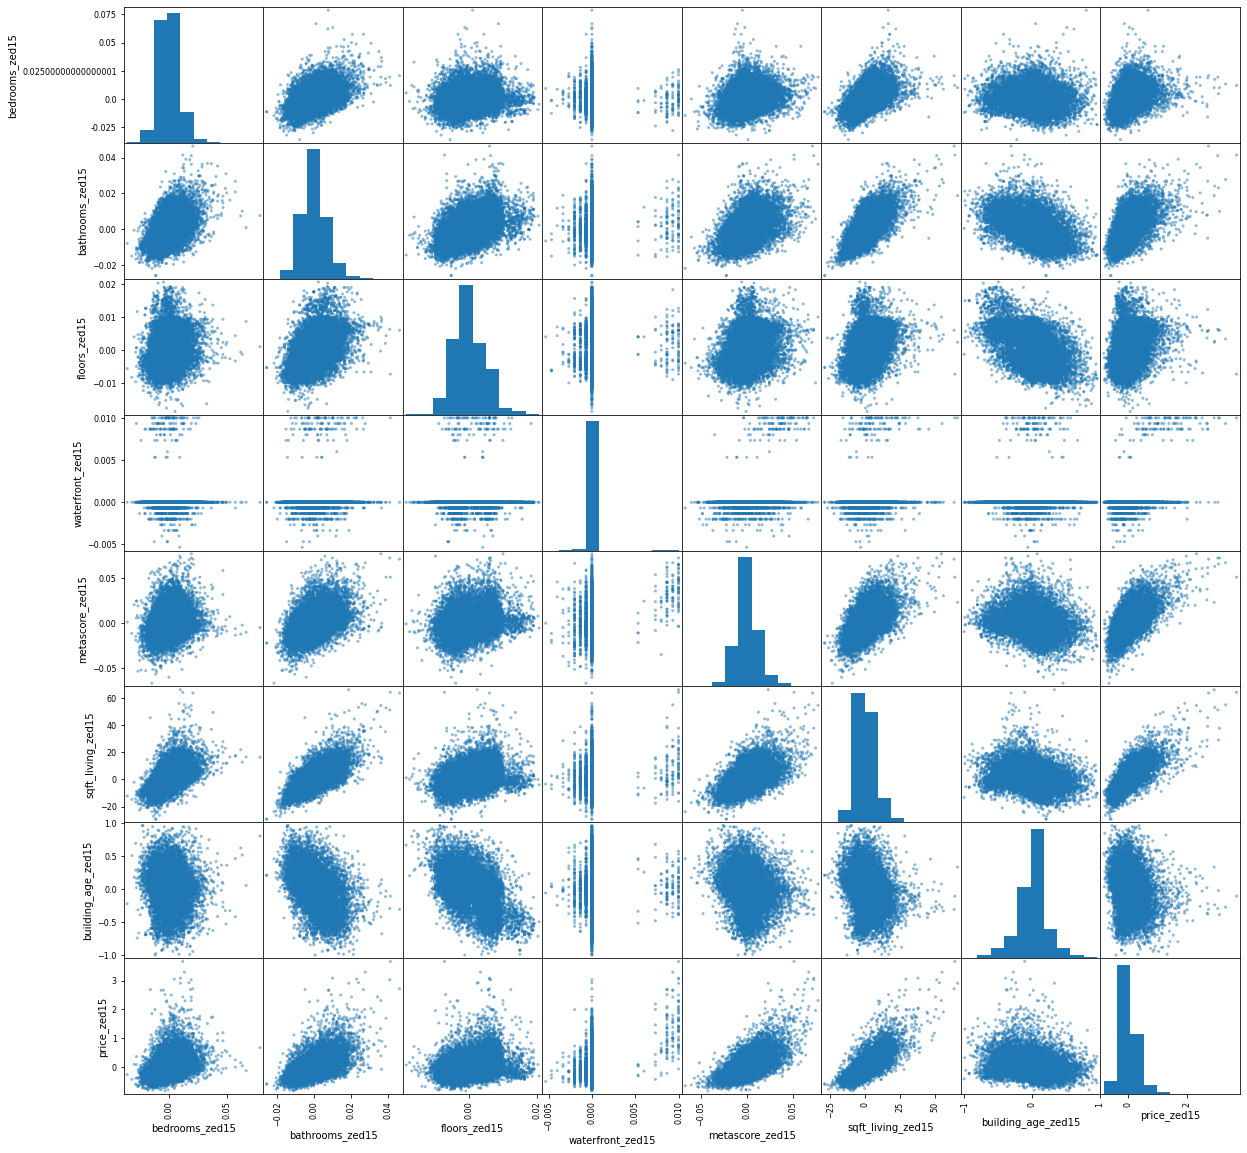

In [7]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20, 20))
plt.show()

==================== df_features CORRELATION PLOT =======================


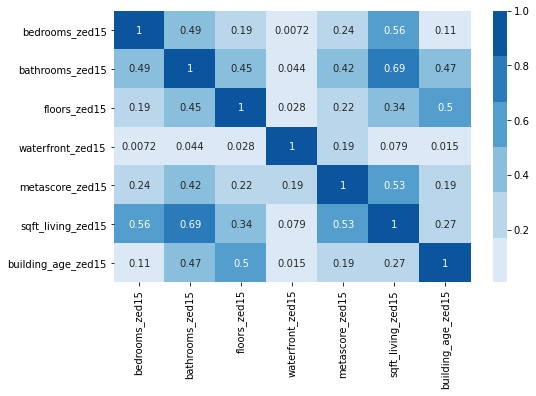



============= vif for column 'bedrooms_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         bedrooms_zed15   R-squared (uncentered):                   0.351
Model:                            OLS   Adj. R-squared (uncentered):              0.351
Method:                 Least Squares   F-statistic:                              1942.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          76496.
No. Observations:               21507   AIC:                                 -1.530e+05
Df Residuals:                   21501   BIC:                                 -1.529e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bathrooms_zed15        0.3379      0.011     31.351      0.000       0.317       0.359
floors_zed15          -0.0051      0.012     -0.412      0.680      -0.029       0.019
waterfront_zed15      -0.5014      0.067     -7.470      0.000      -0.633      -0.370
metascore_zed15       -0.0557      0.005    -12.131      0.000      -0.065      -0.047
sqft_living_zed15      0.0005   9.74e-06     55.257      0.000       0.001       0.001
building_age_zed15     0.0047      0.000     18.204      0.000       0.004       0.005
==============================================================================
Omnibus:                     1767.590   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4727.497
Skew:                           0.470   Prob(JB):                         0.00
Kurtosis:                       5.096   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'bedrooms_zed15' has vif of 1.5419493240976416


============= vif for column 'bathrooms_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        bathrooms_zed15   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              5260.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          86821.
No. Observations:               21507   AIC:                                 -1.736e+05
Df Residuals:                   21501   BIC:                                 -1.736e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bedrooms_zed15         0.1294      0.004     31.351      0.000       0.121       0.137
floors_zed15           0.1714      0.007     22.866      0.000       0.157       0.186
waterfront_zed15      -0.0124      0.042     -0.297      0.766      -0.094       0.069
metascore_zed15        0.0306      0.003     10.767      0.000       0.025       0.036
sqft_living_zed15      0.0004   5.75e-06     74.009      0.000       0.000       0.000
building_age_zed15    -0.0075      0.000    -49.845      0.000      -0.008      -0.007
==============================================================================
Omnibus:                     1039.857   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2006.099
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       4.310   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'bathrooms_zed15' has vif of 2.467908115173205


============= vif for column 'floors_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           floors_zed15   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              1669.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          89117.
No. Observations:               21507   AIC:                                 -1.782e+05
Df Residuals:                   21501   BIC:                                 -1.782e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bedrooms_zed15        -0.0016      0.004     -0.412      0.680      -0.009       0.006
bathrooms_zed15        0.1385      0.006     22.866      0.000       0.127       0.150
waterfront_zed15       0.0917      0.037      2.453      0.014       0.018       0.165
metascore_zed15        0.0073      0.003      2.860      0.004       0.002       0.012
sqft_living_zed15     5.7e-05   5.77e-06      9.875      0.000    4.57e-05    6.83e-05
building_age_zed15    -0.0079      0.000    -59.458      0.000      -0.008      -0.008
==============================================================================
Omnibus:                      559.431   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              736.972
Skew:                           0.312   Prob(JB):                    9.30e-161
Kurtosis:                       3.657   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'floors_zed15' has vif of 1.4657332271994399


============= vif for column 'waterfront_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       waterfront_zed15   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                              154.9
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                   2.36e-193
Time:                        08:32:11   Log-Likelihood:                      1.2571e+05
No. Observations:               21507   AIC:                                 -2.514e+05
Df Residuals:                   21501   BIC:                                 -2.514e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bedrooms_zed15        -0.0052      0.001     -7.470      0.000      -0.007      -0.004
bathrooms_zed15       -0.0003      0.001     -0.297      0.766      -0.003       0.002
floors_zed15           0.0031      0.001      2.453      0.014       0.001       0.005
metascore_zed15        0.0117      0.000     25.461      0.000       0.011       0.013
sqft_living_zed15   1.704e-06   1.06e-06      1.615      0.106   -3.64e-07    3.77e-06
building_age_zed15     0.0002   2.62e-05      7.206      0.000       0.000       0.000
==============================================================================
Omnibus:                    34073.523   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16526470.124
Skew:                          10.454   Prob(JB):                         0.00
Kurtosis:                     137.183   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'waterfront_zed15' has vif of 1.0432367228384845


============= vif for column 'metascore_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        metascore_zed15   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              1670.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          68042.
No. Observations:               21507   AIC:                                 -1.361e+05
Df Residuals:                   21501   BIC:                                 -1.360e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bedrooms_zed15        -0.1222      0.010    -12.131      0.000      -0.142      -0.102
bathrooms_zed15        0.1753      0.016     10.767      0.000       0.143       0.207
floors_zed15           0.0520      0.018      2.860      0.004       0.016       0.088
waterfront_zed15       2.4980      0.098     25.461      0.000       2.306       2.690
sqft_living_zed15      0.0008   1.43e-05     58.871      0.000       0.001       0.001
building_age_zed15    -0.0007      0.000     -1.748      0.081      -0.001    8.13e-05
==============================================================================
Omnibus:                     1854.544   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4760.765
Skew:                           0.505   Prob(JB):                         0.00
Kurtosis:                       5.072   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'metascore_zed15' has vif of 1.465923632394211


============= vif for column 'sqft_living_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      sqft_living_zed15   R-squared (uncentered):                   0.613
Model:                            OLS   Adj. R-squared (uncentered):              0.613
Method:                 Least Squares   F-statistic:                              5686.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                         -62986.
No. Observations:               21507   AIC:                                  1.260e+05
Df Residuals:                   21501   BIC:                                  1.260e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
bedrooms_zed15       231.1586      4.183     55.257      0.000     222.959     239.358
bathrooms_zed15      477.3731      6.450     74.009      0.000     464.730     490.016
floors_zed15          79.2124      8.021      9.875      0.000      63.490      94.935
waterfront_zed15      71.1425     44.058      1.615      0.106     -15.214     157.499
metascore_zed15      164.8507      2.800     58.871      0.000     159.362     170.339
building_age_zed15     1.3931      0.169      8.234      0.000       1.061       1.725
==============================================================================
Omnibus:                     4059.682   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17470.987
Skew:                           0.873   Prob(JB):                         0.00
Kurtosis:                       7.056   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

column 'sqft_living_zed15' has vif of 2.586834854832398


============= vif for column 'building_age_zed15' ===================


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     building_age_zed15   R-squared (uncentered):                   0.346
Model:                            OLS   Adj. R-squared (uncentered):              0.346
Method:                 Least Squares   F-statistic:                              1895.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          6110.6
No. Observations:               21507   AIC:                                 -1.221e+04
Df Residuals:                   21501   BIC:                                 -1.216e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bedrooms_zed15        3.2503      0.179     18.204      0.000       2.900       3.600
bathrooms_zed15     -13.7231      0.275    -49.845      0.000     -14.263     -13.183
floors_zed15        -17.8278      0.300    -59.458      0.000     -18.416     -17.240
waterfront_zed15     12.7623      1.771      7.206      0.000       9.291      16.234
metascore_zed15      -0.2122      0.121     -1.748      0.081      -0.450       0.026
sqft_living_zed15     0.0023      0.000      8.234      0.000       0.002       0.003
==============================================================================
Omnibus:                     1565.234   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5221.396
Skew:                           0.342   Prob(JB):                         0.00
Kurtosis:                       5.315   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

column 'building_age_zed15' has vif of 1.5287549847706619



In [8]:

print(f"==================== df_features CORRELATION PLOT =======================")
plot_corr(df_features)
print()


for col_c in df_features.columns:
    print(f"\n============= vif for column {repr(col_c)} ===================")
    vif = calculate_vif(df=df_features, target_col=col_c, show_res=True)
    print(f"column {repr(col_c)} has vif of {vif}")
    print(f"==============================================================\n")

In [9]:
# ======================================================
#       OLS Regression Model 
#      
# Michael Collins, Flatiron School
# 2020-10-30_0939_MDT
#
# ======================================================

ols = sf.check_model(
    df=df_clean, 
    features_to_use=cols_feature,
    target_col=col_target, 
    add_constant=False, 
    show_summary=True, 
    vif_threshold=3.0)

                                 OLS Regression Results                                
Dep. Variable:            price_zed15   R-squared (uncentered):                   0.683
Model:                            OLS   Adj. R-squared (uncentered):              0.683
Method:                 Least Squares   F-statistic:                              6611.
Date:                Sat, 31 Oct 2020   Prob (F-statistic):                        0.00
Time:                        08:32:11   Log-Likelihood:                          6716.8
No. Observations:               21507   AIC:                                 -1.342e+04
Df Residuals:                   21500   BIC:                                 -1.336e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [10]:
ols

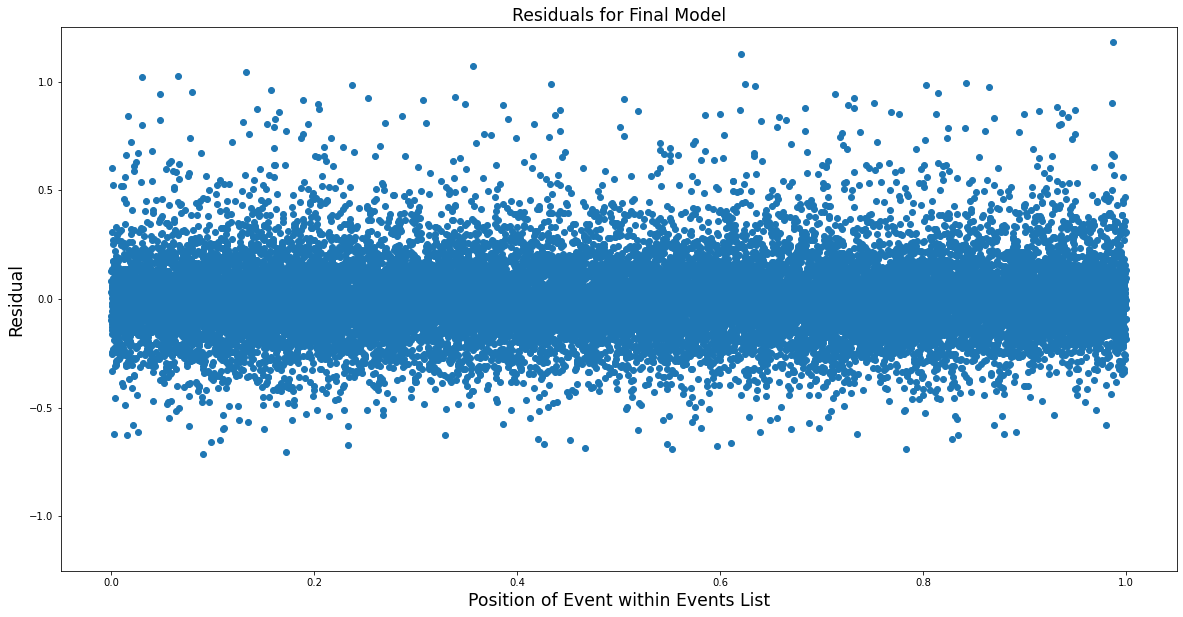

len(ols.resid) = 21507
====== outlier eventIndices =======
outlier_eventIndices = [656, 1418, 2862, 7693, 13398, 21328]



In [11]:
# plot residuals
ols_resid = ols.resid
x_axis = np.linspace(0, 1, len(ols_resid))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, ols_resid)
y_min = -1.25
y_max = 1.25
plt.ylim(y_min, y_max)
plt.ylabel("Residual", fontsize='xx-large')
plt.xlabel("Position of Event within Events List", fontsize='xx-large')
plt.title("Residuals for Final Model", fontsize='xx-large')
plt.show()


print(f"len(ols.resid) = {len(ols.resid)}")
ols_eventIndex = df_clean[col_eventIndex]
ols_resid = ols.resid
ols_eventIndex_resid = list(zip(ols_eventIndex, ols_resid))
outlier_eventIndices = []
for eventIndex, resid in ols_eventIndex_resid:
    resid_min = -1
    resid_max = 1
    if not (resid_min <= resid <= resid_max):
        outlier_eventIndices.append(eventIndex)
print(f"====== outlier eventIndices =======")
print(f"outlier_eventIndices = {repr(outlier_eventIndices)}\n")

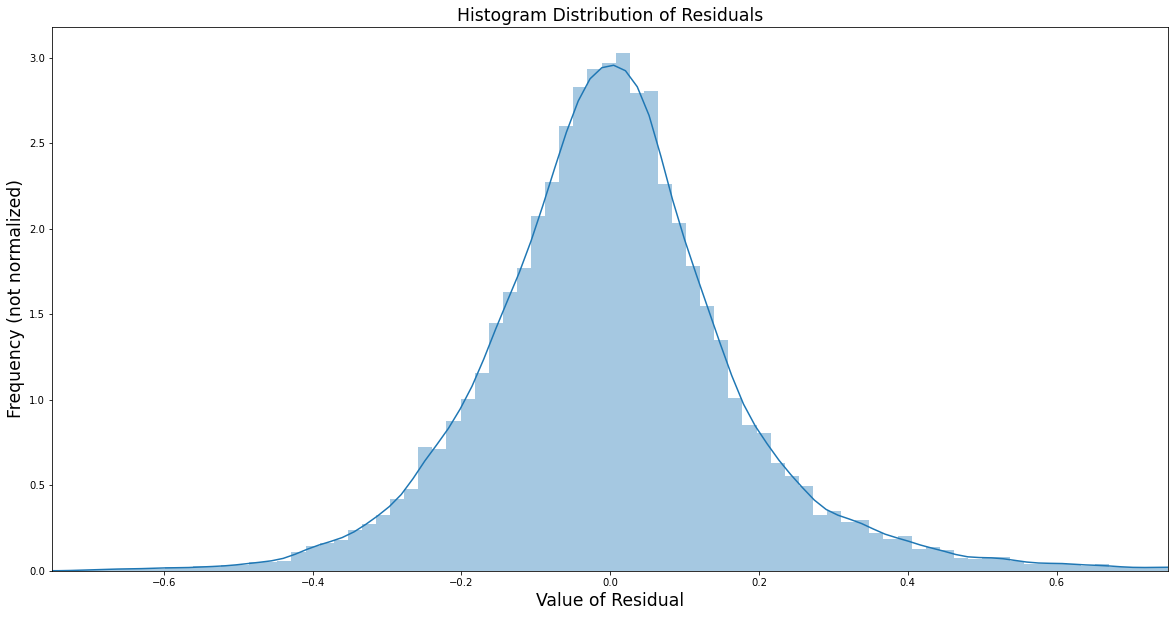

In [12]:
plt.figure(figsize=(20,10))
sns.distplot(ols.resid, bins=100)
x_min = np.min(ols.resid)
x_max = np.max(ols.resid)
x_min = -0.75
x_max = 0.75
plt.xlim(x_min, x_max)
plt.title("Histogram Distribution of Residuals", fontsize='xx-large')
plt.ylabel("Frequency (not normalized)", fontsize='xx-large')
plt.xlabel("Value of Residual", fontsize='xx-large')

plt.show()

In [13]:
# How can we test that our residuals are normal? 
# H0: data is normal
# HA: data is not normal
scs.shapiro(ols.resid)

# p = 0.87 -> fail to reject the null, therefore residuals are normally distributed 

ShapiroResult(statistic=0.9581159353256226, pvalue=0.0)

In [14]:
df_map = df.loc[df[col_eventValid] == True]
display(df_map)

eventIndex  eventValid          id       date     price  bedrooms  \
0               0           1  7129300520 2014-10-13  221900.0         3   
1               1           1  6414100192 2014-12-09  538000.0         3   
2               2           1  5631500400 2015-02-25  180000.0         2   
3               3           1  2487200875 2014-12-09  604000.0         4   
4               4           1  1954400510 2015-02-18  510000.0         3   
...           ...         ...         ...        ...       ...       ...   
21592       21592           1   263000018 2014-05-21  360000.0         3   
21593       21593           1  6600060120 2015-02-23  400000.0         4   
21594       21594           1  1523300141 2014-06-23  402101.0         2   
21595       21595           1   291310100 2015-01-16  400000.0         3   
21596       21596           1  1523300157 2014-10-15  325000.0         2   

       bathrooms  sqft_living  sqft_lot  floors  ...  building_age_phi15  \
0           1.00         1180      5650     1.0  ...                -5.0   
1           2.25         2570      7242     2.0  ...                 0.0   
2           1.00          770     10000     1.0  ...                 5.0   
3           3.00         1960      5000     1.0  ...                -5.0   
4           2.00         1680      8080     1.0  ...                 0.0   
...          ...          ...       ...     ...  ...                 ...   
21592       2.50         1530      1131     3.0  ...                -5.0   
21593       2.50         2310      5813     2.0  ...                -5.0   
21594       0.75         1020      1350     2.0  ...                -5.0   
21595       2.50         1600      2388     2.0  ...                 5.0   
21596       0.75         1020      1076     2.0  ...                -5.0   

       interior_age_mean15  interior_age_median15  interior_age_diff15  \
0                81.066667                   80.0           -16.066667   
1                63.133333                   69.0           -34.133333   
2                29.066667                   25.0            57.933333   
3                49.933333                   65.0             5.066667   
4                34.000000                   33.0            -1.000000   
...                    ...                    ...                  ...   
21592            34.733333                   21.0           -23.733333   
21593            35.800000                   26.0           -29.800000   
21594            46.133333                   17.0           -35.133333   
21595            15.533333                   15.0             0.466667   
21596            46.133333                   17.0           -34.133333   

       interior_age_delta15  interior_age_sigma15  interior_age_MAD15  \
0                     -15.0             27.805195                22.0   
1                     -40.0             15.244088                 2.0   
2                      62.0             14.073458                 8.0   
3                     -10.0             33.235456                30.0   
4                       0.0              3.425395                 1.0   
...                     ...                   ...                 ...   
21592                 -10.0             31.890368                 9.0   
21593                 -20.0             25.771302                20.0   
21594                  -6.0             46.173393                 9.0   
21595                   1.0              1.087300                 0.0   
21596                  -5.0             46.173393                 9.0   

       interior_age_zScore15  interior_age_zed15  interior_age_phi15  
0                  -0.577830           -0.160667                -5.0  
1                  -2.239119           -0.341333                -5.0  
2                   4.116496            0.579333                 5.0  
3                   0.152448            0.050667                -5.0  
4                  -0.291937           -0.010000            

In [15]:
print(f"col_lat = {repr(col_lat)}")
print(f"col_long = {repr(col_long)}")
print()


col_price_mean = f"price_mean{ext_K}"
col_log10_price_mean = f"log10_price_mean{ext_K}"
map_price_mean = df_map[col_price_mean]
map_log10_price_mean = [np.log10(pm) for pm in map_price_mean]
df_map[col_log10_price_mean] = map_log10_price_mean
df_map['resid'] = ols.resid
df_map['resid_qcut'] = pd.qcut(df_map['resid'], 10, labels=False)
display(df_map)

col_lat = 'lat'
col_long = 'long'



eventIndex  eventValid          id       date     price  bedrooms  \
0               0           1  7129300520 2014-10-13  221900.0         3   
1               1           1  6414100192 2014-12-09  538000.0         3   
2               2           1  5631500400 2015-02-25  180000.0         2   
3               3           1  2487200875 2014-12-09  604000.0         4   
4               4           1  1954400510 2015-02-18  510000.0         3   
...           ...         ...         ...        ...       ...       ...   
21592       21592           1   263000018 2014-05-21  360000.0         3   
21593       21593           1  6600060120 2015-02-23  400000.0         4   
21594       21594           1  1523300141 2014-06-23  402101.0         2   
21595       21595           1   291310100 2015-01-16  400000.0         3   
21596       21596           1  1523300157 2014-10-15  325000.0         2   

       bathrooms  sqft_living  sqft_lot  floors  ...  interior_age_diff15  \
0           1.00         1180      5650     1.0  ...           -16.066667   
1           2.25         2570      7242     2.0  ...           -34.133333   
2           1.00          770     10000     1.0  ...            57.933333   
3           3.00         1960      5000     1.0  ...             5.066667   
4           2.00         1680      8080     1.0  ...            -1.000000   
...          ...          ...       ...     ...  ...                  ...   
21592       2.50         1530      1131     3.0  ...           -23.733333   
21593       2.50         2310      5813     2.0  ...           -29.800000   
21594       0.75         1020      1350     2.0  ...           -35.133333   
21595       2.50         1600      2388     2.0  ...             0.466667   
21596       0.75         1020      1076     2.0  ...           -34.133333   

       interior_age_delta15  interior_age_sigma15  interior_age_MAD15  \
0                     -15.0             27.805195                22.0   
1                     -40.0             15.244088                 2.0   
2                      62.0             14.073458                 8.0   
3                     -10.0             33.235456                30.0   
4                       0.0              3.425395                 1.0   
...                     ...                   ...                 ...   
21592                 -10.0             31.890368                 9.0   
21593                 -20.0             25.771302                20.0   
21594                  -6.0             46.173393                 9.0   
21595                   1.0              1.087300                 0.0   
21596                  -5.0             46.173393                 9.0   

       interior_age_zScore15  interior_age_zed15  interior_age_phi15  \
0                  -0.577830           -0.160667                -5.0   
1                  -2.239119           -0.341333                -5.0   
2                   4.116496            0.579333                 5.0   
3                   0.152448            0.050667                -5.0   
4                  -0.291937           -0.010000                 0.0   
...                      ...                 ...                 ...   
21592              -0.744216           -0.237333                -5.0   
21593              -1.156325           -0.298000                -5.0   
21594              -0.760900           -0.351333                -5.0   
21595               0.429198            0.004667                 5.0   
21596              -0.739242           -0.341333                -5.0   

       log10_price_mean15     resid  resid_qcut  
0                5.583093 -0.095058           2  
1                5.588119  0.129875           8  
2                5.672929 -0.076329           2  
3                5.801701  0.030506           5  
4                5.704879  0.084684           7  
...                   ...       ...         ...  
21592            5.613169 -0.185004           1  
21593            5.524205 -

In [16]:
# ============================================================
#   Make a pretty map of selected data from the data frame.
# ============================================================

mapbox_access_token = open(r"c:\.mapbox\access_token").read()

px.set_mapbox_access_token(mapbox_access_token)

fig = px.scatter_mapbox(df_map,
                        lat=col_lat,
                        lon=col_long, 
                        color=col_log10_price_mean,
                        size=col_grade,
                        color_continuous_scale="Inferno",
                        size_max=6,
                        zoom=10, title=f"log10(Mean Price of {ext_K} nearest Neighbors)")
fig.update_layout(autosize=False,
                  width=1000,
                  height=800)

fig.show()

In [17]:
# ============================================================
#   Make a pretty map of selected data from the data frame.
# ============================================================

mapbox_access_token = open(r"c:\.mapbox\access_token").read()

px.set_mapbox_access_token(mapbox_access_token)

fig = px.scatter_mapbox(df_map,
                        lat=col_lat,
                        lon=col_long, 
                        color='resid_qcut',
                        size=col_grade,
                        color_continuous_scale="Inferno",
                        size_max=6,
                        zoom=10, title="residual deciles by location")
fig.update_layout(autosize=False,
                  width=1000,
                  height=800)
fig.show()

In [18]:
print(df_raw.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'KNN', 'building_age',
       'interior_age', 'log10_price'],
      dtype='object')


In [19]:
# ================================================
#    Take a detailed look at the raw values 
#    in columns whose values may be categorical
#
#    Michael Collins, Flatiron School
#    2020-10-30_0455_MDT
# ================================================

cols_examine = list(df_raw.columns)
cols_summarized = []
quanta_all = []
for col_c in cols_examine:
    items_c = sorted(list(dict(df_raw[col_c].value_counts()).items()))
    num_c = len(items_c)
    if num_c < 50:
        cols_summarized.append(col_c)
        print(f"==== {repr(col_c)} =====")
        quanta_c = [repr(k) for k, v in items_c]
        quanta_all.append(f"quanta_{col_c} = {quanta_c}")
        for k, v in items_c:
            s_k = str(k) + " " * (8-len(str(k)))
            print(s_k, v)
        print()
        
print(f"==== COLUMNS_SUMMARIZED =====")
print(f"cols_summarized = {repr(cols_summarized)}\n")
        
print(f"==== QUANTA_SUMMARIZED =====")
print(f"quanta_summarized =")
for s in quanta_all:
    print(s)
print()



==== 'bedrooms' =====
1        196
2        2760
3        9824
4        6882
5        1601
6        272
7        38
8        13
9        6
10       3
11       1
33       1

==== 'bathrooms' =====
0.5      4
0.75     71
1.0      3851
1.25     9
1.5      1445
1.75     3048
2.0      1930
2.25     2047
2.5      5377
2.75     1185
3.0      753
3.25     589
3.5      731
3.75     155
4.0      136
4.25     79
4.5      100
4.75     23
5.0      21
5.25     13
5.5      10
5.75     4
6.0      6
6.25     2
6.5      2
6.75     2
7.5      1
7.75     1
8.0      2

==== 'floors' =====
1.0      10673
1.5      1910
2.0      8235
2.5      161
3.0      611
3.5      7

==== 'waterfront' =====
0        21451
1        146

==== 'view' =====
0        19485
1        330
2        957
3        508
4        317

==== 'condition' =====
1        29
2        170
3        14020
4        5677
5        1701

==== 'grade' =====
3        1
4        27
5        242
6        2038
7        8974
8        6065
9        2615
10